# Job change prediction


## Wprowadzenie

Firma działająca w obszarze Big Data i Data Science chce zatrudniać analityków danych wśród osób, które pomyślnie przejdą kursy prowadzone przez firmę. Wiele osób zapisuje się na szkolenie. Firma chce wiedzieć, który z kandydatów naprawdę chce pracować w firmie po szkoleniu lub po prostu szuka nowego zatrudnienia, ponieważ pomaga to obniżyć koszty i zaoszczędzić czas oraz dostosować jakość szkolenia czy planowanie kursów.
<br><br>
Zadaniem jest wykorzystać dostępne dane do utworzenia modelu, który pozwoli firmie zaklasyfikować nowych kandydatów do dwóch grup: target-pozytywnej (osoby, które z większym prawdopodobieństwem chcą zmienić obecną pracę i podjąć ją u organizatora, bądź rozpocząć u niego swoją pierwszą pracę) oraz analogicznie odwrotnie – target-negatywnej (osoby, które z mniejszym prawdopodobieństwem będą zainteresowane lub zaangażowane pracą u organizatora).

<br><br>
Cechy dostępne w oryginalnym zestawie danych:

* enrollee_id : Unique ID for candidate
* city: City code
* city_ development _index : Developement index of the city (scaled)
* gender: Gender of candidate
* relevent_experience: Relevant experience of candidate
* enrolled_university: Type of University course enrolled if any
* education_level: Education level of candidate
* major_discipline :Education major discipline of candidate
* experience: Candidate total experience in years
* company_size: No of employees in current employer's company
* company_type : Type of current employer
* lastnewjob: Difference in years between previous job and current job
* training_hours: training hours completed
* target: 0 – Not looking for job change, 1 – Looking for a job change

<br><br>
Projekt będzie realizowany przez klasyfikację danych. Klasyfikatorem będzie ostatnia kolumna: 'target'.
Wartość target=0 oznacza, że kandydat nie szuka pracy u organizatora ; wartość target=1 oznacza, że kandydat będzie zainteresowany możliwością pracy.
<br>

Oryginalny zestaw danych składa się z dwóch plików: 
* "aug_train.csv" - zbiór uczący (pierwotny) - około 19 000 krotek (wierszy) z w pełni kompletną kolumną "target" (zostanie podzielony na zbiór uczący wtórny i testowy wtórny), 
* "aug_test.csv" - około 2000 krotek, które nie zawierają danych "target". Ten plik można traktować jako dane o nowych uczestnikach kursu, których analizę zleca firma.

<br>
Docelowym owocem projektu ma być zatem przygotowanie dla firmy pliku z danymi nowych kursantów (aug_test.csv), z dodaną kolumną "target", której wartości ma przewidzieć nasz model. 
<br>
Zanim będzie to możliwe, pierwotny zbiór uczący ("aug_train.csv") podzielimy na zbiór uczący (wtórny) i testowy (wtórny).
<br>
Przeprowadzimy trening klasyfikatora na zbiorze uczącym wtórnym, następnie przetestujemy model (porównamy wartości przewidywane z faktycznymi) na zbiorze testowym wtórnym. 
<br>
Mając gotowy model i policzoną akceptowalną dokładność, będziemy mogły zrealizować zlecenie firmy na pliku aug_test.csv.
<br>
<br>
Link do zbioru: <br>
https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists?select=aug_train.csv

## Wstępna obróbka i przedstawienie danych

Załadowanie danych.<br>
Opuszczenie kolumn, o których zdecydowano, że nie przydadzą się w tworzeniu modelu.<br>
Wyliczenie wierszy o określonej liczbie wartości brakujących.<br>
Skasowanie wierszy, zawierających najwięcej wartości brakujących.<br>


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
#import scipy.stats
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pylab import rcParams


# Target: 0=not looking for a job chance   1=looking for a job chance


df = pd.read_csv("aug_train.csv", sep=",")
df_not_changed = df.copy(deep=True) 

# Delete useless columns
# enrollee_id - numer porządkowy, nie wnosi żadnej informacji do modelu
# city - kod miasta, można utożsamić z nazwą miasta - nie wnosi informacji do modelu; kolumną, opisującą rzeczywistą cechę miasta jest city development index
# company_type - brakuje zbyt dużo danych, a nie podejrzewamy, aby dane z tej kolumny były bardzo istotne dla modelu
# gender - brakuje danych, których nie chcemy uzupełniać poprzez niestuprocentowy klasyfikator czy wartości losowe. 
df.drop(['enrollee_id', 'city', 'company_type', 'gender'], axis=1, inplace=True)

print("All rows number: ", df.shape[0])
print("Rows, having at least one <null> value: ", df.shape[0]- df.dropna().shape[0])
print("Almost 50% of rows (after 4 columns-drop!) afected by at least one <null> value.")


df['count_missing'] = df.isnull().sum(axis=1)
print("Max number of missing values in a row: ", df['count_missing'].max())
print("Min number of missing values in a row: ", df['count_missing'].min())
print(df['count_missing'].value_counts())

#df.drop(df.loc[df['count_missing']==6].index, inplace=True)
df.drop(df.loc[df['count_missing']==5].index, inplace=True)

print("Deleted rows, where number of missing values is more or equal 5.")
print("Now, all rows number: ", df.shape[0])



All rows number:  19158
Rows, having at least one <null> value:  7359
Almost 50% of rows (after 4 columns-drop!) afected by at least one <null> value.
Max number of missing values in a row:  5
Min number of missing values in a row:  0
0    11799
1     5211
2     1705
3      324
4      103
5       16
Name: count_missing, dtype: int64
Deleted rows, where number of missing values is more or equal 5.
Now, all rows number:  19142


In [2]:
import plotly.express as px

fig = px.pie(values=[(df.shape[0] - (df.shape[0]- df.dropna().shape[0])), (df.shape[0]- df.dropna().shape[0])], 
             names =['full rows', 'rows having at least one missing value'],title = 'Overview of missing values',template='ggplot2')
fig.show()




fig = px.pie(df['relevent_experience'].value_counts(dropna=False), values='relevent_experience', 
             names = df['relevent_experience'].value_counts(dropna=False).index,title = 'relevent_experience',template='ggplot2')
fig.show()




fig = px.pie(df['enrolled_university'].value_counts(dropna=False), values='enrolled_university', 
             names = df['enrolled_university'].value_counts(dropna=False).index,title = 'enrolled_university',template='ggplot2')
fig.show()



fig = px.pie(df['education_level'].value_counts(dropna=False), values='education_level', 
             names = df['education_level'].value_counts(dropna=False).index,title = 'education_level',template='ggplot2')
fig.show()


fig = px.pie(df['major_discipline'].value_counts(dropna=False), values='major_discipline', 
             names = df['major_discipline'].value_counts(dropna=False).index,title = 'major_discipline',template='ggplot2')
fig.show()



fig = px.pie(df['experience'].value_counts(dropna=False), values='experience', 
             names = df['experience'].value_counts(dropna=False).index,title = 'experience',template='ggplot2')
fig.show()



fig = px.pie(df['company_size'].value_counts(dropna=False), values='company_size', 
             names = df['company_size'].value_counts(dropna=False).index,title = 'company_size',template='ggplot2')
fig.show()




fig = px.pie(df['last_new_job'].value_counts(dropna=False), values='last_new_job', 
             names = df['last_new_job'].value_counts(dropna=False).index,title = 'last_new_job',template='ggplot2')
fig.show()



fig = px.pie(df['target'].value_counts(dropna=False), values='target', 
             names = df['target'].value_counts(dropna=False).index,title = 'target',template='ggplot2')
fig.show()


Zauważamy, że niemal 40 % rekordów zawiera brakujące dane. Pierwsze przychodzące do głowy rozwiązanie problemu brakujących danych - usunąć wybrakowane rekordy - nie wchodzi w grę, z obawy o utratę innych, znaczących dla budowania modeli danych. Z tego względu, brakujące dane będziemy uzupełniać na różne sposoby.

## Praca z wartościami brakującymi, kolumna po kolumnie

W każdym przypadku (poza kolumną target) zamiana wartości kategorycznych na numeryczne odbywa się w ten sposób, że zaczynamy od wartości 1 (a nie 0, jak narzuca OrdinalEncoder). Chcemy uniknąć ewentualnego zerowania się czynników we wzorze modelu. <br><br>
Pozbywanie się wartości brakujących, zamiana tekstowych danych na dane numeryczne.

In [3]:

# enrolee id - odrzucone
# city - odrzucone
# city development index - bez brakujących danych
# gender - odrzucamy


# relevent experience - bez brakujących danych, zamieniamy na 1 i 2
cat_rel_experience = ['No relevent experience', 'Has relevent experience']
oe_rel_exp = OrdinalEncoder(categories=[cat_rel_experience])
df['relevent_experience'] = oe_rel_exp.fit_transform(df[['relevent_experience']])
df['relevent_experience'] = df['relevent_experience'] + 1


# enrolled university - 1% braków, wypełniam najpopularnijszą wartością => no_enrollment
imp_enrolled_uni = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
temp = np.array(df['enrolled_university']).reshape((len(df['enrolled_university']), 1))
df['enrolled_university'] = imp_enrolled_uni.fit_transform(temp)
cat_enrolled_uni = ['Full time course', 'Part time course', 'no_enrollment']
oe_enrolled_uni = OrdinalEncoder(categories=[cat_enrolled_uni])
df['enrolled_university'] = oe_enrolled_uni.fit_transform(df[['enrolled_university']])
df['enrolled_university'] = df['enrolled_university'] + 1


# education level - brakuje 2%, wypełniamy najpopularniejszym
imp_education_level = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
temp = np.array(df['education_level']).reshape((len(df['education_level']), 1))
df['education_level'] = imp_education_level.fit_transform(temp)
cat_edu_level = ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd']
oe_education_level = OrdinalEncoder(categories=[cat_edu_level])
df['education_level'] = oe_education_level.fit_transform(df[['education_level']])
df['education_level'] = df['education_level'] + 1


# major discipline - brakuje 15 %, wypełniamy najpopularniejszym
imp_major = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
temp = np.array(df['major_discipline']).reshape((len(df['major_discipline']), 1))
df['major_discipline'] = imp_major.fit_transform(temp)
cat_major = ['No Major','Arts','Other','Humanities','Business Degree','STEM']
oe_major = OrdinalEncoder(categories=[cat_major])
df['major_discipline'] = oe_major.fit_transform(df[['major_discipline']])
df['major_discipline'] = df['major_discipline'] + 1


#experience - brakuje 5 (<1%), losujemy wartość ze zbioru możliwych, zamiana szczególnych danych na liczby
df['experience'] = df['experience'].replace('<1','0')
df['experience'] = df['experience'].replace('>20','21')
def f(s):
    out = s.to_numpy().copy()
    mask = s.isna().to_numpy()
    out[mask] = np.random.choice(out[~mask], mask.sum())
    return out
df['experience'] = f(df['experience'])
#print(df['experience'].unique())
cat_experience = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
oe_experience = OrdinalEncoder(categories=[cat_experience])
df['experience'] = oe_experience.fit_transform(df[['experience']])
df['experience'] = df['experience'] + 1


# company size - 31% brakuje, wypełniamy losując spośród możliwych wartości, zamieniamy na ordinal encoder
df['company_size'] = f(df['company_size'])
cat_company_size = ['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
oe_company_size = OrdinalEncoder(categories=[cat_company_size])
df['company_size'] = oe_company_size.fit_transform(df[['company_size']])
df['company_size'] = df['company_size'] + 1


# company type - 32% brakuje, opuszczamy całą kolumnę


# last new job - 2% brakuje, losujemy
df['last_new_job'] = f(df['last_new_job'])
cat_last_new_job = ['never', '1', '2', '3', '4', '>4']
oe_last_new_job = OrdinalEncoder(categories=[cat_last_new_job])
df['last_new_job'] = oe_last_new_job.fit_transform(df[['last_new_job']])
df['last_new_job'] = df['last_new_job'] + 1


# training hours - nic nie brakuje

df.drop(['count_missing'], axis=1, inplace=True) # "nasza" kolumna robocza



##############################################
#### Teraz mamy kolumny:

###* city_development_index
###* relevent_experience
###* enrolled_university
###* education_level
###* major_discipline
###* experience
###* company_size
###* last_new_job
###* training_hours
###* target
##############################################



In [4]:
fig = px.pie(values=[(df.shape[0] - (df.shape[0]- df.dropna().shape[0])), (df.shape[0]- df.dropna().shape[0])], 
             names =['full rows', 'rows having at least one missing value'],title = 'Overview of missing values',template='ggplot2')
fig.show()




fig = px.pie(df['relevent_experience'].value_counts(dropna=False), values='relevent_experience', 
             names = df['relevent_experience'].value_counts(dropna=False).index,title = 'relevent_experience',template='ggplot2')
fig.show()




fig = px.pie(df['enrolled_university'].value_counts(dropna=False), values='enrolled_university', 
             names = df['enrolled_university'].value_counts(dropna=False).index,title = 'enrolled_university',template='ggplot2')
fig.show()



fig = px.pie(df['education_level'].value_counts(dropna=False), values='education_level', 
             names = df['education_level'].value_counts(dropna=False).index,title = 'education_level',template='ggplot2')
fig.show()


fig = px.pie(df['major_discipline'].value_counts(dropna=False), values='major_discipline', 
             names = df['major_discipline'].value_counts(dropna=False).index,title = 'major_discipline',template='ggplot2')
fig.show()



fig = px.pie(df['experience'].value_counts(dropna=False), values='experience', 
             names = df['experience'].value_counts(dropna=False).index,title = 'experience',template='ggplot2')
fig.show()



fig = px.pie(df['company_size'].value_counts(dropna=False), values='company_size', 
             names = df['company_size'].value_counts(dropna=False).index,title = 'company_size',template='ggplot2')
fig.show()




fig = px.pie(df['last_new_job'].value_counts(dropna=False), values='last_new_job', 
             names = df['last_new_job'].value_counts(dropna=False).index,title = 'last_new_job',template='ggplot2')
fig.show()



Powyższe diagramy dowodzą skutecznego pozbycia się danych brakujących

## Histogramy kolumn (pyplot)

Komentarz:
* city_development_index: wartość numeryczna, ciągła. Obserwujemy tendencję wzrostową (więcej kandydatów pochodzi z większych / bardziej rozwiniętych miast). Histogram lewoskośny.
* relevent_experience: histogram wartości kategorycznej binarnej. 
* enrolled_university: Histogram wartości kategorycznej. Zdecydowana większość kandydatów nie uczestniczy "obecnie" w studiach.
* education_level: Histogram wartości kategorycznej. Rozkład przypomina histogram rozkładu normalnego. Poziom wykształcenia wśród uczestników wzrasta do kategorii ukończenia studiów I stopnia, następnie spada.
* major_discipline: Histogram wartości kategorycznej. Zdecydowana większość uczestników kształciła się w kierunkach STEM (Science, Technology, Engineering, Mathematics).
* experience: Histogram wartości dyskretniej. Krańce nieznane - wartości krańcowe oznaczają zakres miejszy / większy niż dana wartość. Histogram, bez interpretacji jest niewiarygodny. Ostatni słupek góruje częstością nad resztą. Pamiętać jednak należy, iż jest to kategoria ">20". Poza tym słupkiem, wykres histogramu jest dość regularnie prawoskośny. Ostatni słupek należy interpretować jako "długi ogon" wykresu histogramu. Ostatecznie: czym większy czas aktywności zawodowej uczestnika, tym mniej reprezentantów tejże grupy.
* company_size: Histogram wartości kategorycznej. Zbliżony do rozkładu normalnego. Jak wyżej - ostatni słupek jest "długim ogonem" rozkładu.
* last_new_job: jak wyżej.
* training_hours: Histogram wartości numerycznej dyskretnej (pełne godziny). Mocno prawoskośny. Coraz mniej uczestników bierze udział w kursie do końca. Zapał spada wraz z czasem trwania kursu.



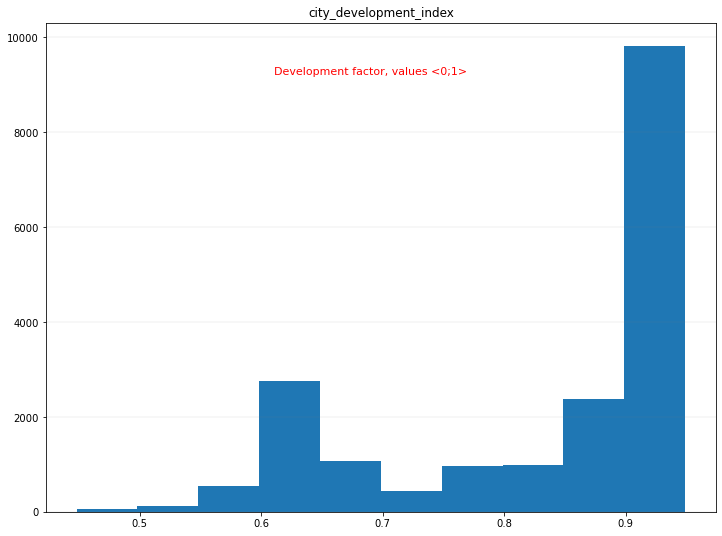

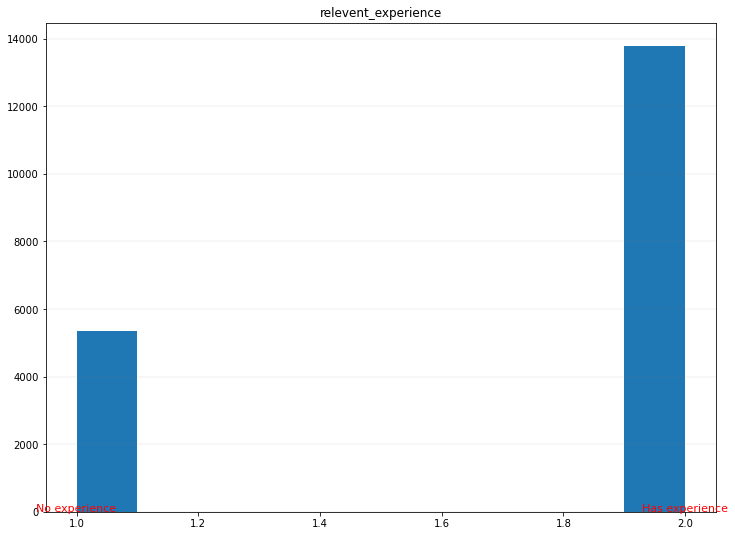

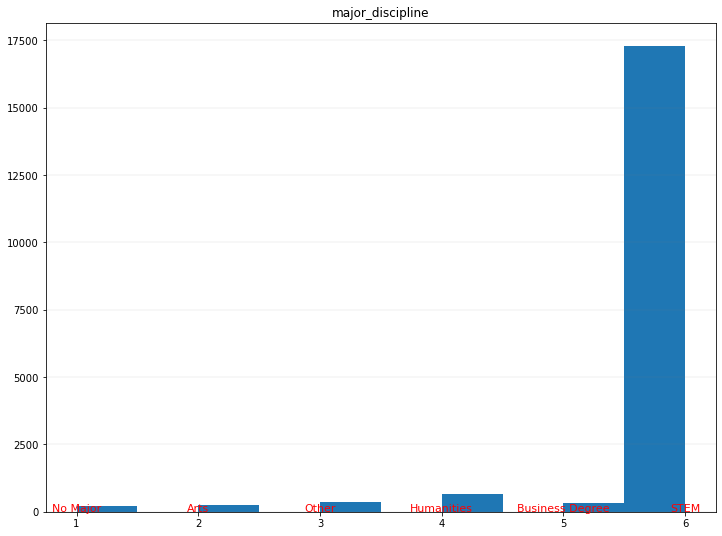

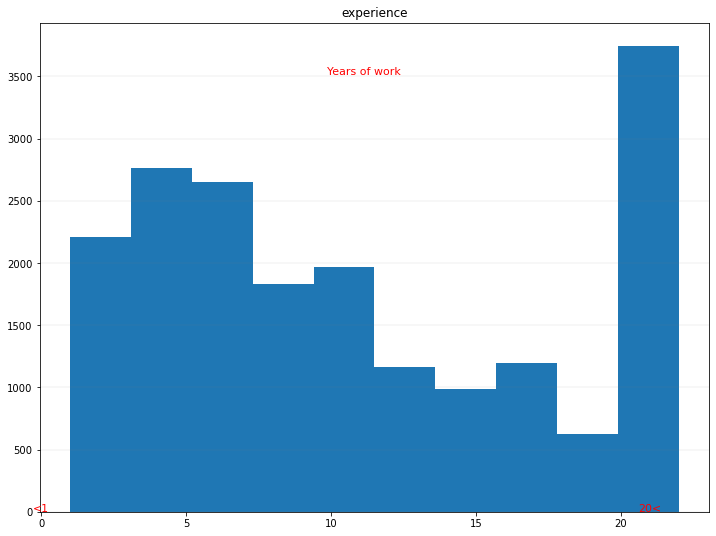

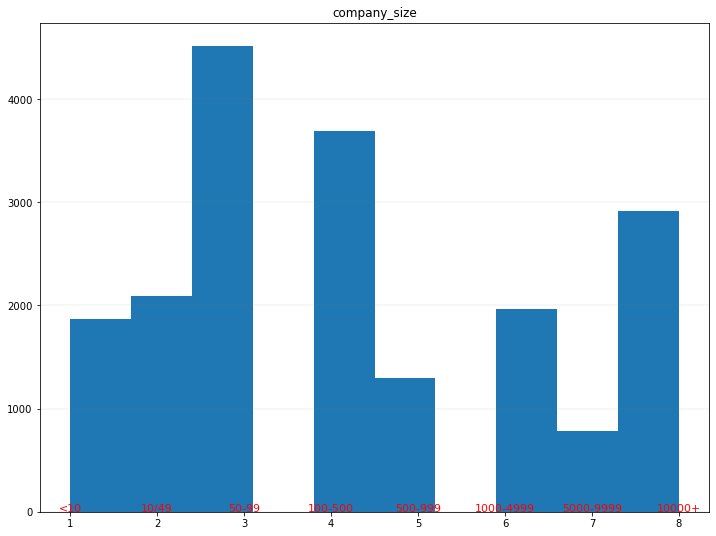

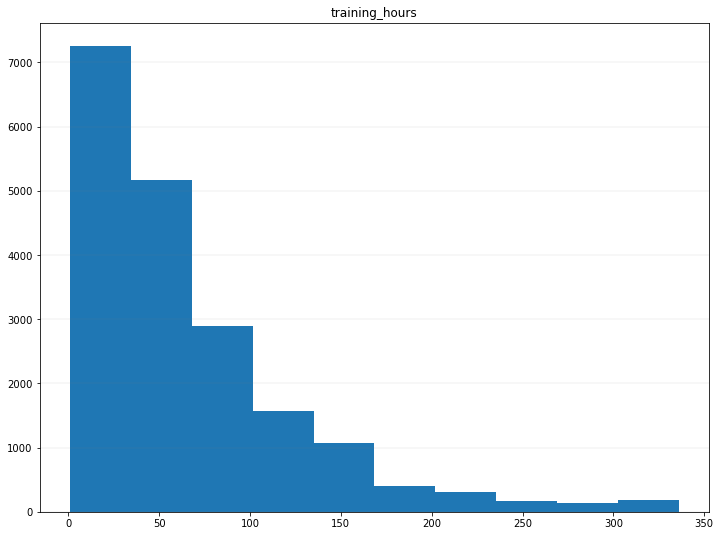

In [5]:
dataset = [df['city_development_index'], df['relevent_experience'], df['enrolled_university'], df['education_level'], df['major_discipline'], df['experience'], df['company_size'], df['last_new_job'], df['training_hours']]
labels = ['city_development_index', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'last_new_job', 'training_hours']

rcParams['figure.figsize'] = 12, 9

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.hist(x=dataset[0], label=[labels[0]])
plt.title(labels[0])
plt.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.hist(x=dataset[1], label=[labels[1]])
plt.title(labels[1])
plt.text(1, 0, 'No experience', horizontalalignment='center', fontsize=11, color='r')
plt.text(2, 0, 'Has experience', horizontalalignment='center', fontsize=11, color='r')
plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.hist(x=dataset[2], label=[labels[2]])
plt.title(labels[2])
plt.text(1, 0, 'Full-time', horizontalalignment='center', fontsize=11, color='r')
plt.text(2, 0, 'Part-time', horizontalalignment='center', fontsize=11, color='r')
plt.text(3, 0, 'No enrollment', horizontalalignment='center', fontsize=11, color='r')
plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.hist(x=dataset[3], label=[labels[3]])
plt.title(labels[3])
plt.text(1, 0, 'Primary School', horizontalalignment='center', fontsize=11, color='r')
plt.text(2, 0, 'High School', horizontalalignment='center', fontsize=11, color='r')
plt.text(3, 0, 'Graduate', horizontalalignment='center', fontsize=11, color='r')
plt.text(4, 0, 'Masters', horizontalalignment='center', fontsize=11, color='r')
plt.text(5, 0, 'Phd', horizontalalignment='center', fontsize=11, color='r')
plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.hist(x=dataset[4], label=[labels[4]])
plt.title(labels[4])
plt.text(1, 0, 'No Major', horizontalalignment='center', fontsize=11, color='r')
plt.text(2, 0, 'Arts', horizontalalignment='center', fontsize=11, color='r')
plt.text(3, 0, 'Other', horizontalalignment='center', fontsize=11, color='r')
plt.text(4, 0, 'Humanities', horizontalalignment='center', fontsize=11, color='r')
plt.text(5, 0, 'Business Degree', horizontalalignment='center', fontsize=11, color='r')
plt.text(6, 0, 'STEM', horizontalalignment='center', fontsize=11, color='r')
plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.hist(x=dataset[5], label=[labels[5]])
plt.title(labels[5])
plt.figtext(0.5,0.8, "Years of work", horizontalalignment='center', fontsize=11, color='r')
plt.text(0, 0, '<1', horizontalalignment='center', fontsize=11, color='r')
plt.text(21, 0, '20<', horizontalalignment='center', fontsize=11, color='r')
plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.hist(x=dataset[6], label=[labels[6]])
plt.title(labels[6])
plt.text(1, 0, '<10', horizontalalignment='center', fontsize=11, color='r')
plt.text(2, 0, '10/49', horizontalalignment='center', fontsize=11, color='r')
plt.text(3, 0, '50-99', horizontalalignment='center', fontsize=11, color='r')
plt.text(4, 0, '100-500', horizontalalignment='center', fontsize=11, color='r')
plt.text(5, 0, '500-999', horizontalalignment='center', fontsize=11, color='r')
plt.text(6, 0, '1000-4999', horizontalalignment='center', fontsize=11, color='r')
plt.text(7, 0, '5000-9999', horizontalalignment='center', fontsize=11, color='r')
plt.text(8, 0, '10000+', horizontalalignment='center', fontsize=11, color='r')
plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.hist(x=dataset[7], label=[labels[7]])
plt.title(labels[7])
plt.figtext(0.5,0.8, "Years of work in last(current) job", horizontalalignment='center', fontsize=11, color='r')
plt.text(1, 0, 'never', horizontalalignment='center', fontsize=11, color='r')
plt.text(6, 0, '>4', horizontalalignment='center', fontsize=11, color='r')
plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.hist(x=dataset[8], label=[labels[8]])
plt.title(labels[8])
plt.show()




## Histogramy seaborn (wybrane)

Komentarz:
* city_development_index & target - wywnioskowano, w kandydaci z mniej rozwiniętych miast (<0.7) są w większym stosunku nastawieni na zmianę pracy (vel podjęcie pracy w "naszej" firmie IT), niż kandydaci z rozwiniętych miast.
* bez względu na to, czy patrzymy na grupę studentów dziennych, zaocznych, czy niestudiujących - w większości są to osoby, które nie szukają zmiany pracy i podjęcia jej "u nas".
* major_discipline & relevent_experience - można się spodziewać, że osoby, posiadające doświadczenie z dziedziny IT (zapewne zdobyte na własną rękę) stanowią większość w każdej grup dziedziny wykształcenia.

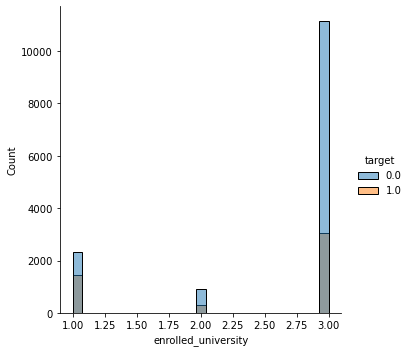

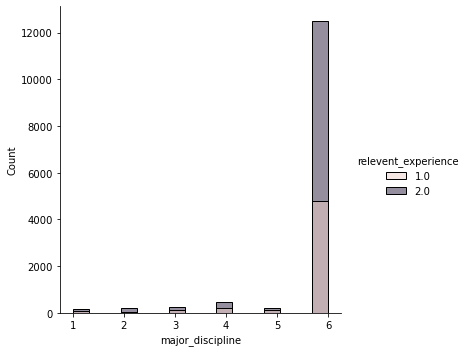

In [6]:
sns.displot(df, x='city_development_index', hue='target')
plt.show()

sns.displot(df, x='enrolled_university', hue='target')
plt.show()

sns.displot(df, x='major_discipline', hue='relevent_experience')
plt.show()


## Boxploty

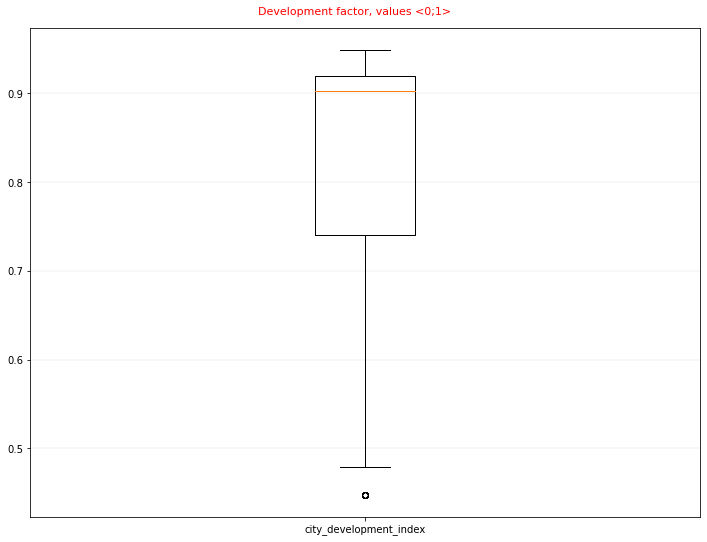

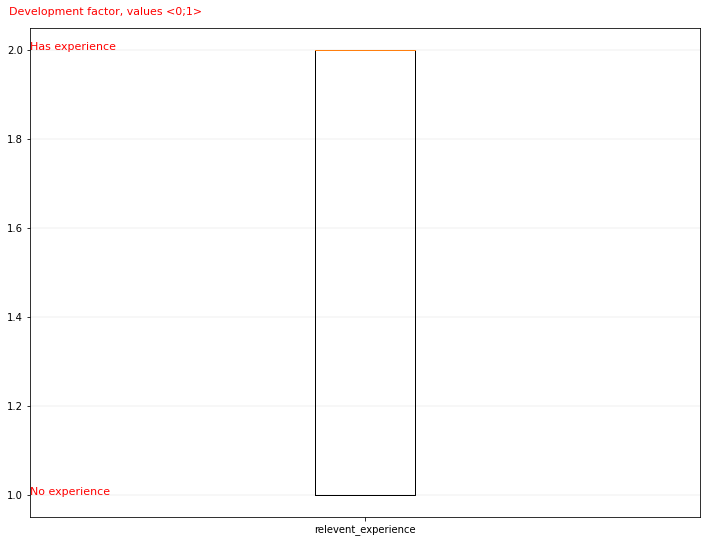

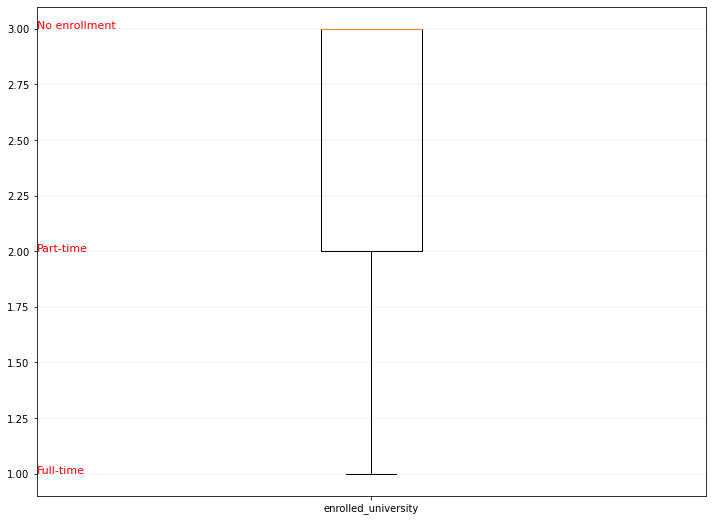

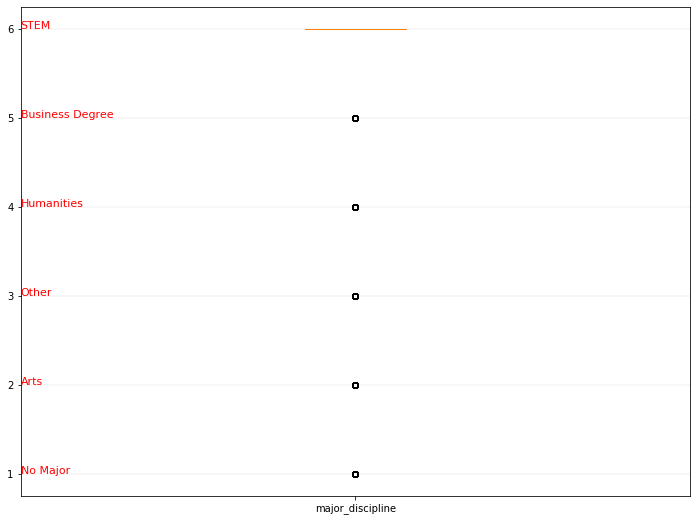

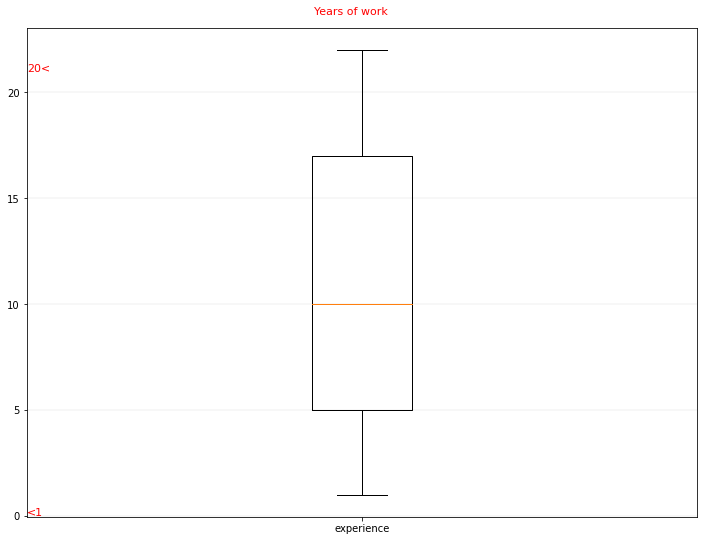

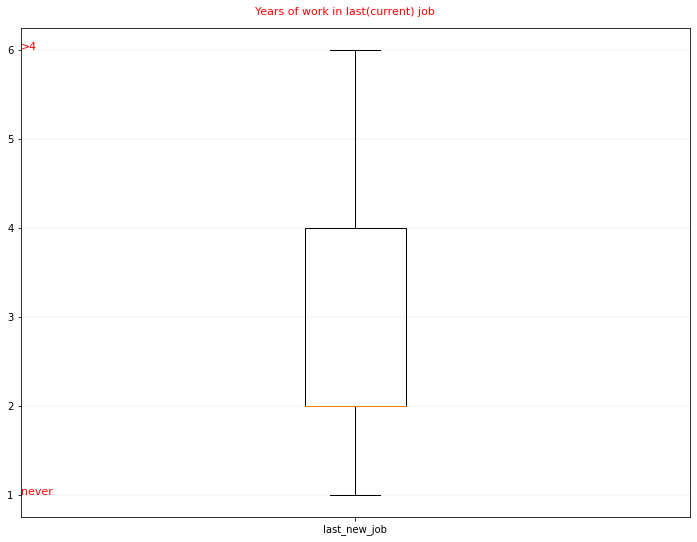

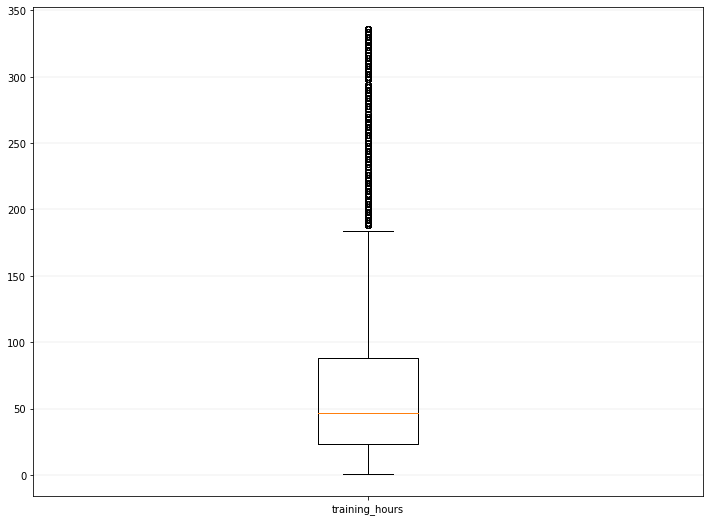

In [7]:
dataset = [df['city_development_index'], df['relevent_experience'], df['enrolled_university'], df['education_level'], df['major_discipline'], df['experience'], df['company_size'], df['last_new_job'], df['training_hours']]
labels = ['city_development_index', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'last_new_job', 'training_hours']


fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.boxplot(x=dataset[0], labels=[labels[0]])
plt.figtext(0.5,0.9, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')
plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.boxplot(x=dataset[1], labels=[labels[1]])
plt.figtext(0.1,0.9, "Development factor, values <0;1>", fontsize=11, color='r')
plt.text(0.5, 1, 'No experience', fontsize=11, color='r')
plt.text(0.5, 2, 'Has experience', fontsize=11, color='r')
plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.boxplot(x=dataset[2], labels=[labels[2]])
plt.text(0.5, 1, 'Full-time', fontsize=11, color='r')
plt.text(0.5, 2, 'Part-time', fontsize=11, color='r')
plt.text(0.5, 3, 'No enrollment', fontsize=11, color='r')
plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.boxplot(x=dataset[3], labels=[labels[3]])
plt.text(0.5, 1, 'Primary School', fontsize=11, color='r')
plt.text(0.5, 2, 'High School', fontsize=11, color='r')
plt.text(0.5, 3, 'Graduate', fontsize=11, color='r')
plt.text(0.5, 4, 'Masters', fontsize=11, color='r')
plt.text(0.5, 5, 'Phd', fontsize=11, color='r')
plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.boxplot(x=dataset[4], labels=[labels[4]])
plt.text(0.5, 1, 'No Major', fontsize=11, color='r')
plt.text(0.5, 2, 'Arts', fontsize=11, color='r')
plt.text(0.5, 3, 'Other', fontsize=11, color='r')
plt.text(0.5, 4, 'Humanities', fontsize=11, color='r')
plt.text(0.5, 5, 'Business Degree', fontsize=11, color='r')
plt.text(0.5, 6, 'STEM', fontsize=11, color='r')
plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.boxplot(x=dataset[5], labels=[labels[5]])
plt.figtext(0.5,0.9, "Years of work", horizontalalignment='center', fontsize=11, color='r')
plt.text(0.5, 0, '<1', fontsize=11, color='r')
plt.text(0.5, 21, '20<', fontsize=11, color='r')
plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.boxplot(x=dataset[6], labels=[labels[6]])
plt.text(0.5, 1, '<10', fontsize=11, color='r')
plt.text(0.5, 2, '10/49', fontsize=11, color='r')
plt.text(0.5, 3, '50-99', fontsize=11, color='r')
plt.text(0.5, 4, '100-500', fontsize=11, color='r')
plt.text(0.5, 5, '500-999', fontsize=11, color='r')
plt.text(0.5, 6, '1000-4999', fontsize=11, color='r')
plt.text(0.5, 7, '5000-9999', fontsize=11, color='r')
plt.text(0.5, 8, '10000+', fontsize=11, color='r')
plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.boxplot(x=dataset[7], labels=[labels[7]])
plt.figtext(0.5,0.9, "Years of work in last(current) job", horizontalalignment='center', fontsize=11, color='r')
plt.text(0.5, 1, 'never', fontsize=11, color='r')
plt.text(0.5, 6, '>4', fontsize=11, color='r')
plt.show()

fig = plt.figure()
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.boxplot(x=dataset[8], labels=[labels[8]])
plt.show()



## Tablica korelacji

Jak widać, poszczególne kolumny mają niską korelację międzzy sobą, również z kolumną 'target'.<br>
Największy współczynnik korelacji wynosi około 46% (experience - last new job). <br>
Wybrano korelację Spearmana ze względu na to, że większość naszych kolumn zawiera wartości kategoryczne, a nie ciągłe liczbowe.

Mapa kolorów diagramu została dopasowana tak, by kolor biały odpowiadał wartości 0.0, a więc zerowej korelacji. Kolory czerowne odpowiadają korelacji dodatniej a niebieskie - ujemniej

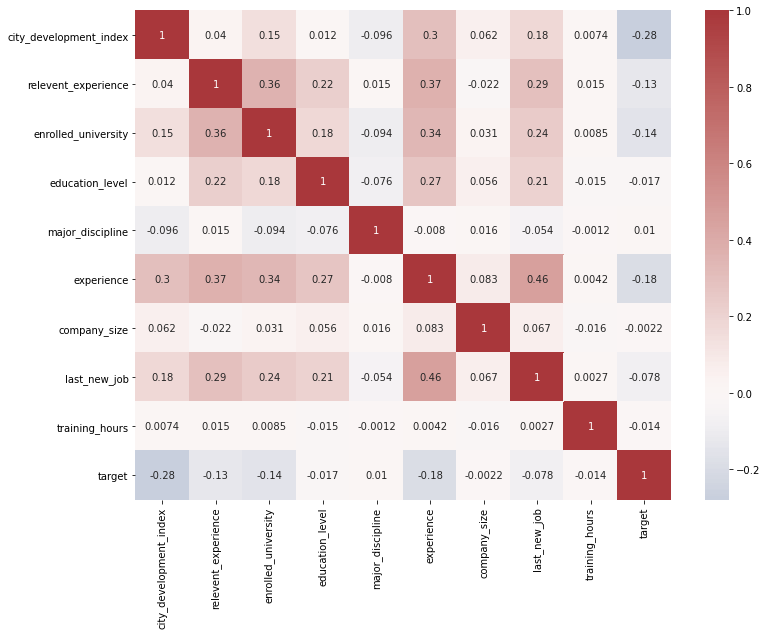

In [8]:
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)

#print(df.corr(method='spearman'))

corrMatrix = df.corr(method='spearman')
sns.heatmap(corrMatrix, annot=True, cmap='vlag', center=0.0)
plt.show()


## Scatter-ploty (wybrane)

Dwa pierwsze to wykresy najbardziej skorelowanych cech. I niestety, na poniższych widokach tej korelacji nie widać...
Ostatni wykres zamieszczony dlatego, iż jest to skrzyżowanie dwóch cech naturalnie (w oryginale) numerycznych.

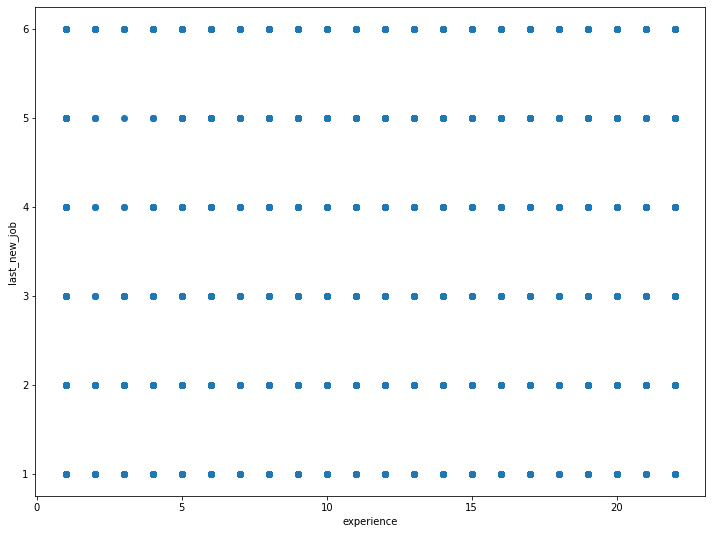

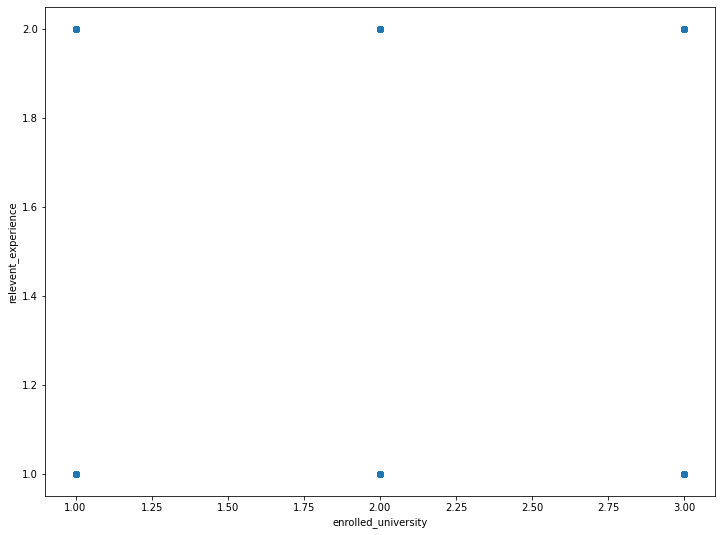

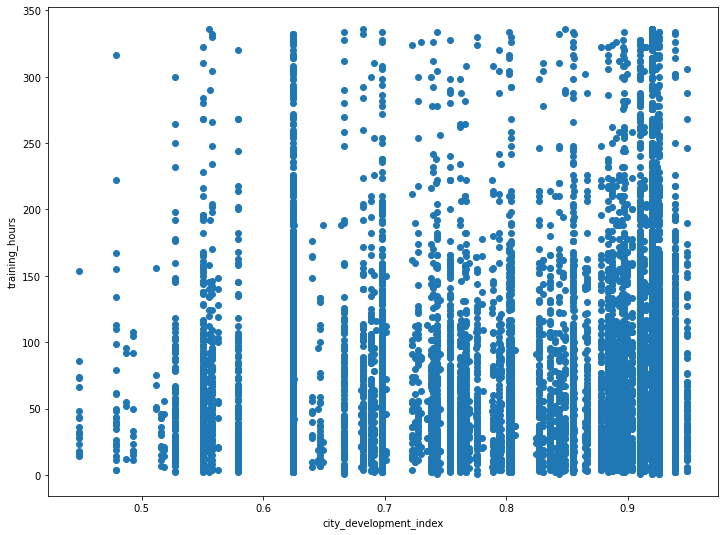

In [9]:
fig = plt.figure()
plt.xlabel('experience')
plt.ylabel('last_new_job')
plt.scatter(x=df['experience'], y=df['last_new_job'])
plt.show()

fig = plt.figure()
plt.xlabel('enrolled_university')
plt.ylabel('relevent_experience')
plt.scatter(x=df['enrolled_university'], y=df['relevent_experience'])
plt.show()

fig = plt.figure()
plt.xlabel('city_development_index')
plt.ylabel('training_hours')
plt.scatter(x=df['city_development_index'], y=df['training_hours'])
plt.show()

## Pairplot (seaborn)

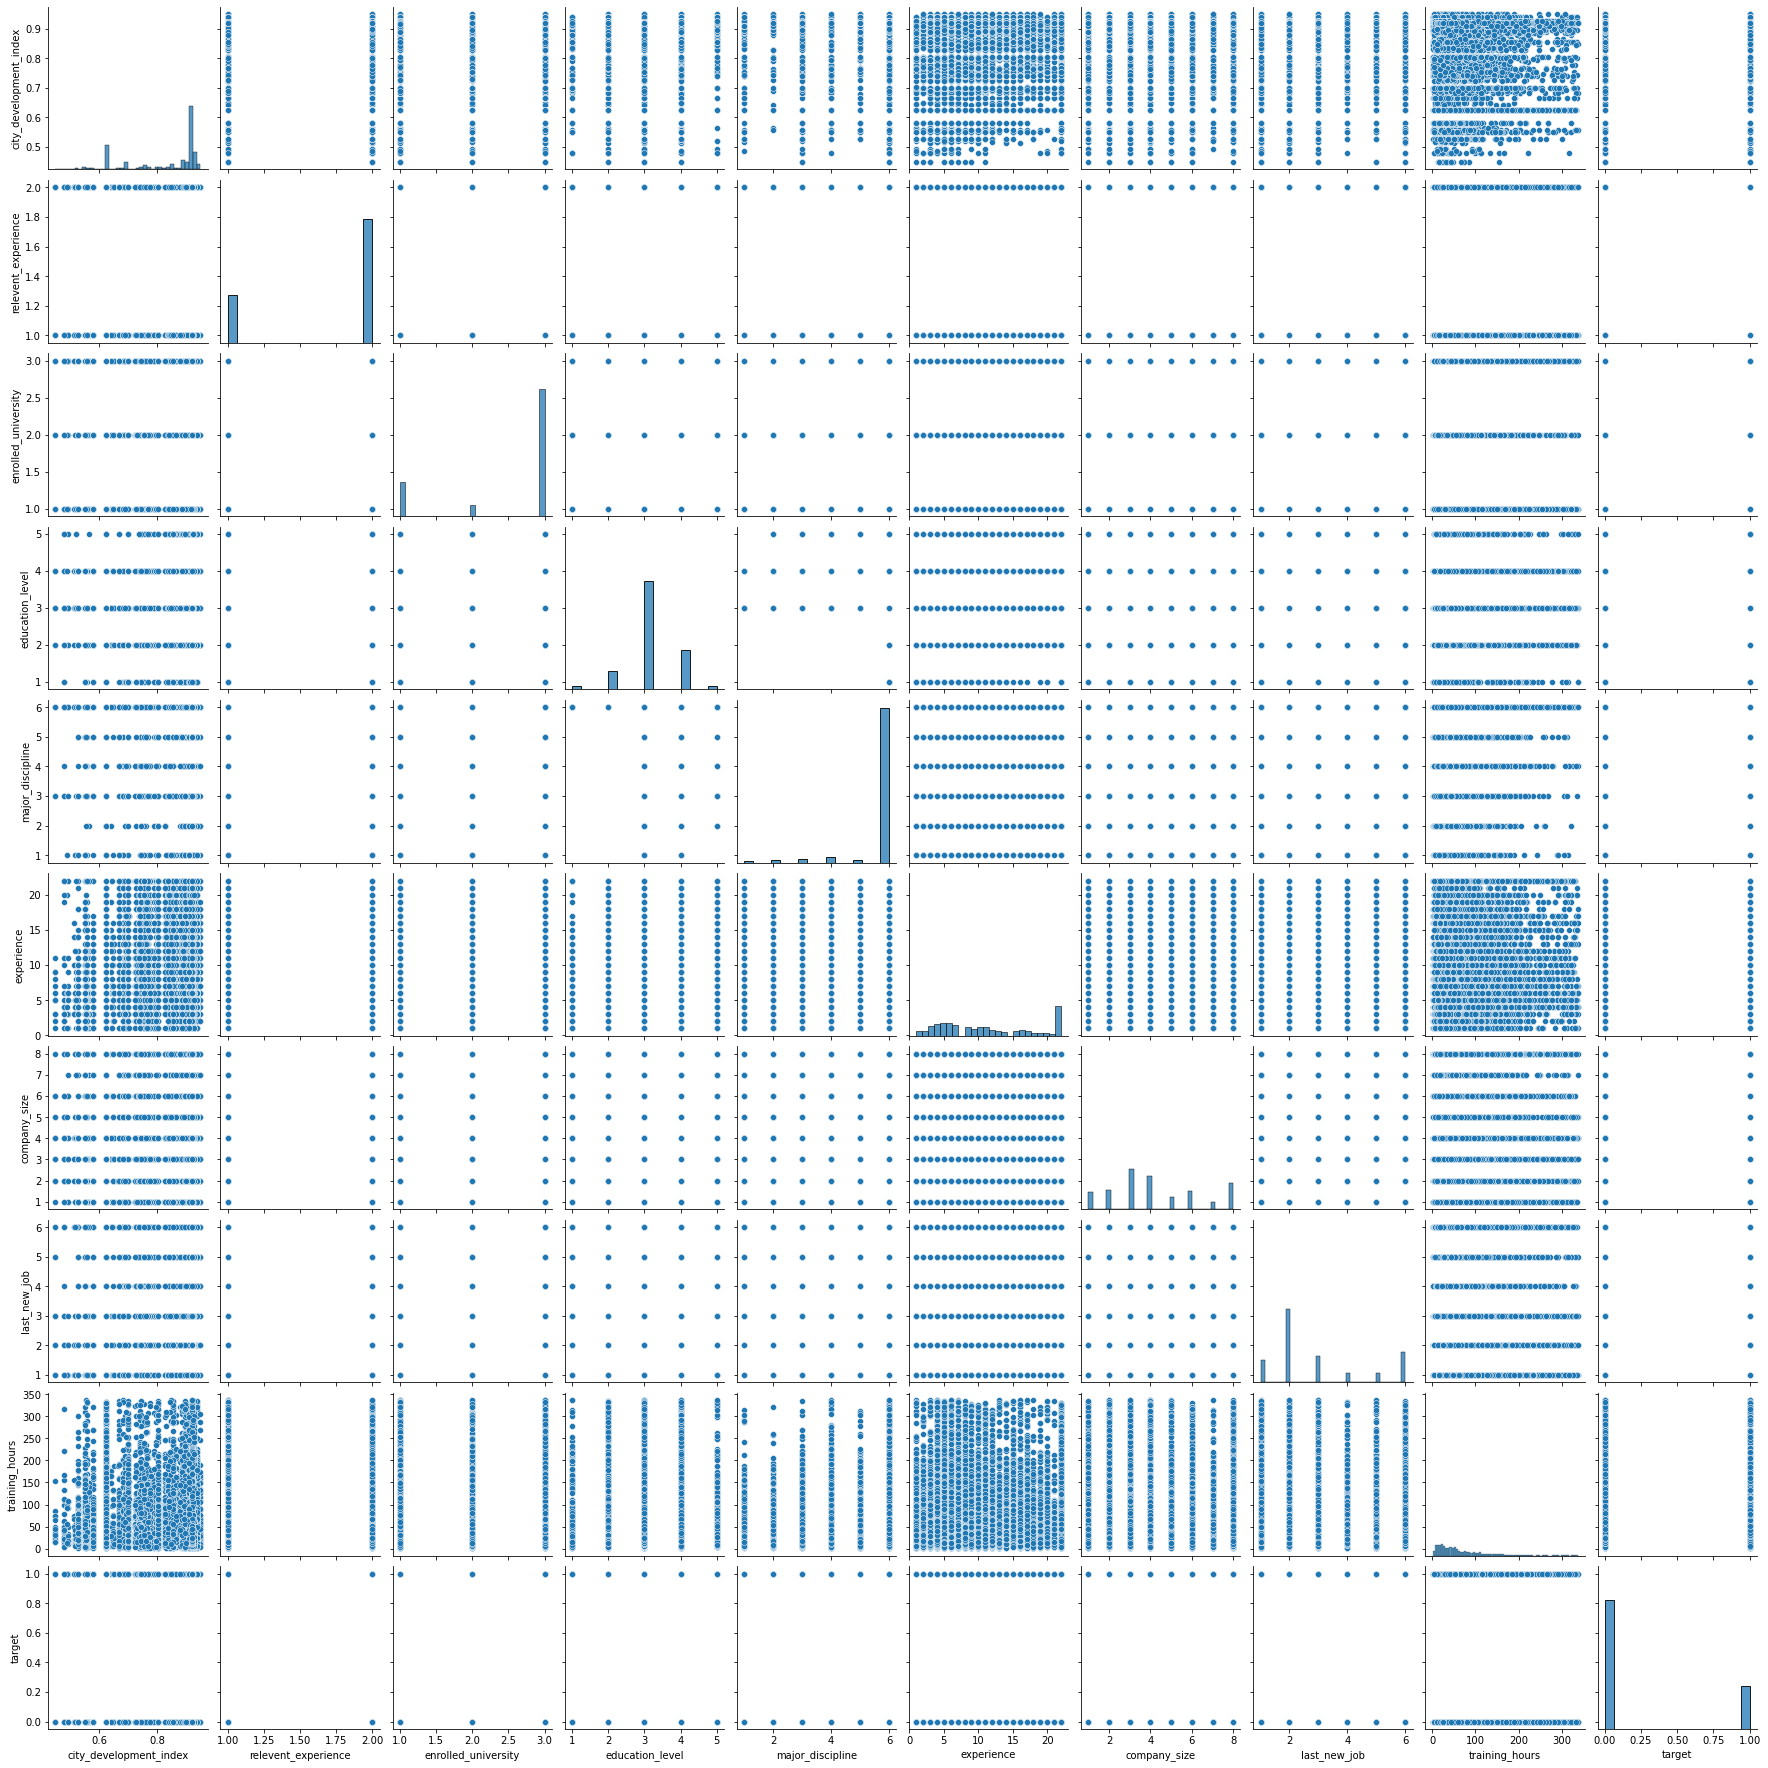

In [10]:

sns.pairplot(df)
plt.show()

## Skalowanie "ręczne"

Skalowanie poprzez własne funkcje.

In [11]:
def minmax(s):
    out = s.copy(deep=True)
    for column in out:
        min = out[column].min()
        max = out[column].max()
        out[column] = out.apply(lambda x: (x[column] - min)/(max - min), axis=1)
    return out

def std(s):
    out = s.copy(deep=True)
    for column in out:
        mean = out[column].mean()
        std_dev = out[column].std()
        out[column] = out.apply(lambda x: (x[column] - mean)/(std_dev), axis=1)
    return out

#d = {'col1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'col2': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
#fake = pd.DataFrame(data=d)
std_manual_scaled_df = std(df)
minmax_manual_scaled_df = minmax(df)

## Skalowanie z biblioteką sklearn

In [12]:
scaler_std = StandardScaler()
scaler_minmax = MinMaxScaler()

std_library_scaled_df = scaler_std.fit_transform(df)
minmax_library_scaled_df = scaler_minmax.fit_transform(df)

std_library_scaled_df = pd.DataFrame(data=std_library_scaled_df, columns=df.columns)
minmax_library_scaled_df = pd.DataFrame(data=minmax_library_scaled_df, columns=df.columns)

## Porównanie histogramów przed vs po skalowaniach

W obrębie jednej cechy zaprezentowano 5 histogramów. Pierwszy to hist. na danych oryginalnych. Następnie standaryzacja ręczna, standaryzacja z sklearn, min-max ręcznie i min-max z sklearn. <br>
Kształty histogramów (a więc względne rozkłady cech) są zachowane. Zmianie ulegają zakresy (oś x). <br>
W przypadku standaryzacji mamy wartości ujemne (kiedy wcześniej ich nie było), natomiast skala min-max rozpoczyna się od 0.

In [13]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
fig.suptitle(labels[0])

#ax1.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax1.hist(x=df['city_development_index'], label=[labels[0]])
ax1.set_title("Before")
#ax1.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

#ax2.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax2.hist(x=std_manual_scaled_df['city_development_index'], label=[labels[0]])
ax2.set_title("Std manual")
#ax2.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

#ax3.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax3.hist(x=std_library_scaled_df['city_development_index'], label=[labels[0]])
ax3.set_title("Std library")
#ax3.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

#ax4.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax4.hist(x=minmax_manual_scaled_df['city_development_index'], label=[labels[0]])
ax4.set_title("Min-max manual")
#ax4.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

#ax5.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax5.hist(x=minmax_library_scaled_df['city_development_index'], label=[labels[0]])
ax5.set_title("Min-max library")
#ax5.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

plt.tight_layout()
plt.show()

#----------------------






In [14]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
fig.suptitle(labels[8])

#ax1.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax1.hist(x=df['training_hours'], label=[labels[8]])
ax1.set_title("Before")
#ax1.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

#ax2.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax2.hist(x=std_manual_scaled_df['training_hours'], label=[labels[8]])
ax2.set_title("Std manual")
#ax2.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

#ax3.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax3.hist(x=std_library_scaled_df['training_hours'], label=[labels[8]])
ax3.set_title("Std library")
#ax3.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

#ax4.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax4.hist(x=minmax_manual_scaled_df['training_hours'], label=[labels[8]])
ax4.set_title("Min-max manual")
#ax4.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

#ax5.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax5.hist(x=minmax_library_scaled_df['training_hours'], label=[labels[8]])
ax5.set_title("Min-max library")
#ax5.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

plt.tight_layout()
plt.show()



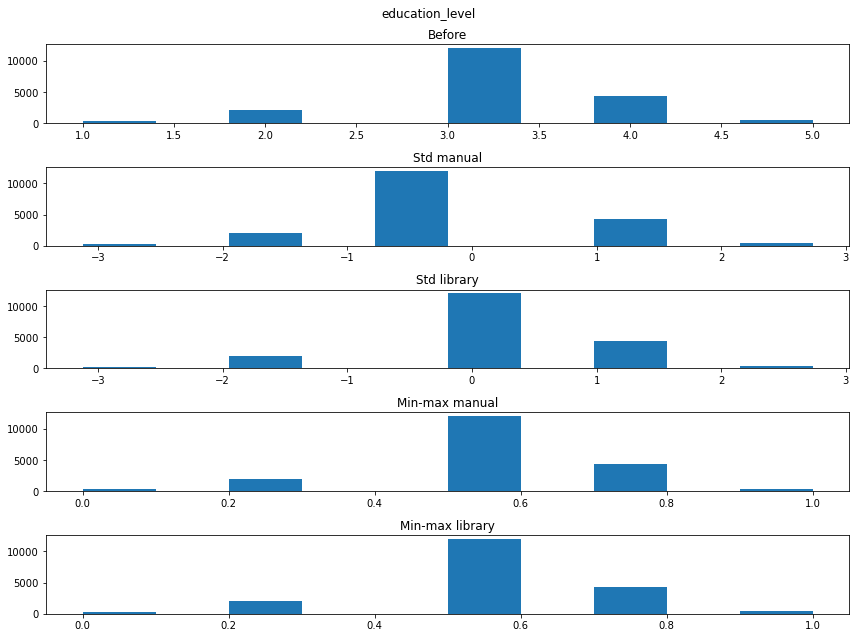

In [15]:
#------------


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
fig.suptitle(labels[3])

#ax1.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax1.hist(x=df['education_level'], label=[labels[3]])
ax1.set_title("Before")
#ax1.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

#ax2.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax2.hist(x=std_manual_scaled_df['education_level'], label=[labels[3]])
ax2.set_title("Std manual")
#ax2.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

#ax3.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax3.hist(x=std_library_scaled_df['education_level'], label=[labels[3]])
ax3.set_title("Std library")
#ax3.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

#ax4.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax4.hist(x=minmax_manual_scaled_df['education_level'], label=[labels[3]])
ax4.set_title("Min-max manual")
#ax4.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

#ax5.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax5.hist(x=minmax_library_scaled_df['education_level'], label=[labels[3]])
ax5.set_title("Min-max library")
#ax5.figtext(0.5,0.8, "Development factor, values <0;1>", horizontalalignment='center', fontsize=11, color='r')

plt.tight_layout()
plt.show()

## Klasyfikacja - Naiwny klasyfikator bayesowski, drzewo decyzyjne, liniowy SVC

Ze względu na kolumnę company_size, której jakość danych jest najsłabsza (duży udział danych brakująch), każdą klasyfikację przeprowadzimy dla trzech wariantów:
<br>
1. Dane brakujące zastąpione wartościami losowymi spośród możliwych (zaimplementowane wyżej jako pierwszy, domyślny sposób)
--------------------------------------------------------------------------------------------
Przytoczenie fragmentu kodu:
<br>
#company size - 31% brakuje, wypełniamy losując spośród możliwych wartości, zamieniamy na ordinal encoder<br>
df['company_size'] = f(df['company_size'])<br>
cat_company_size = ['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']<br>
oe_company_size = OrdinalEncoder(categories=[cat_company_size])<br>
df['company_size'] = oe_company_size.fit_transform(df[['company_size']])<br>
df['company_size'] = df['company_size'] + 1<br>

--------------------------------------------------------------------------------------------
<br>
2. Dane brakujące zastąpione najczęściej występującą wartością
<br>
3. Kolumna wyłączona z procesu tworzenia modelu





Wersja:  1 	[NB]
Precyzja :  0.7400313425039178
F1:  0.5670671803579969
[[3940  410]
 [1083  310]]


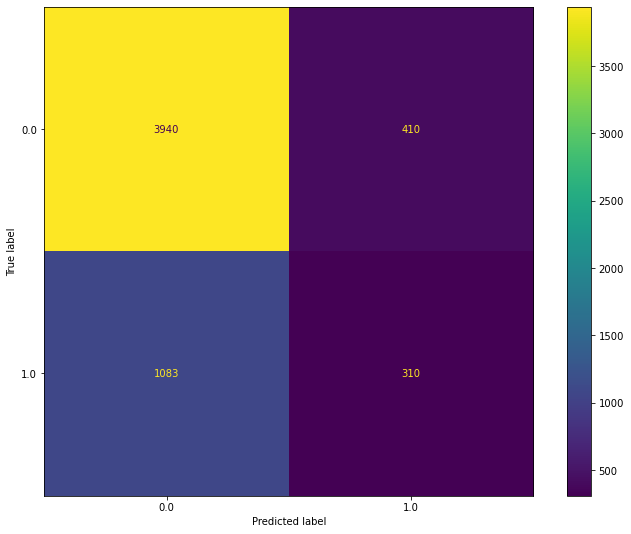




Wersja:  1 	[DT]
accuracy_score :  0.7912240989030124
F1:  0.685095502054216
[[3939  411]
 [ 788  605]]


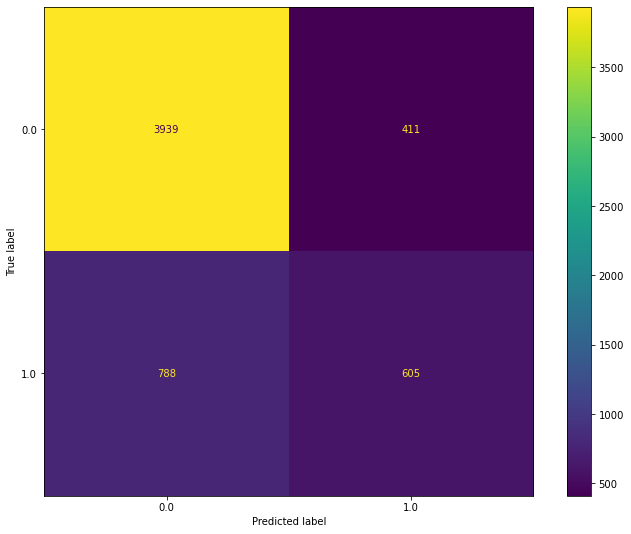




Wersja:  1 	[SVC]
Precyzja :  0.7574438446804805
F1:  0.43099177647874765
[[4350    0]
 [1393    0]]


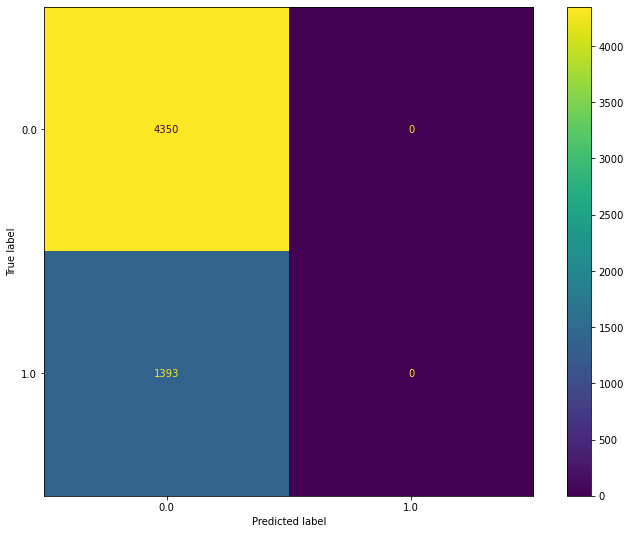




Wersja:  2 	[NB]
Precyzja :  0.7379418422427303
F1:  0.5828170563390513
[[3870  480]
 [1025  368]]





Wersja:  2 	[DT]
accuracy_score :  0.7912240989030124
F1:  0.685095502054216
[[3939  411]
 [ 788  605]]


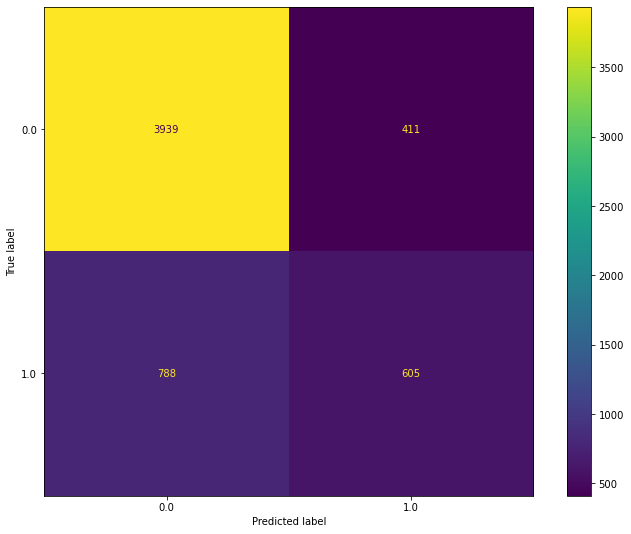




Wersja:  2 	[SVC]
Precyzja :  0.7574438446804805
F1:  0.43099177647874765
[[4350    0]
 [1393    0]]


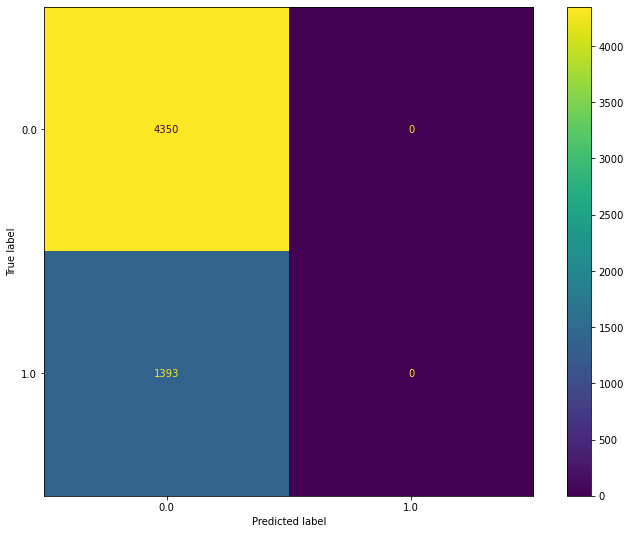




Wersja:  3 	[NB]
Precyzja :  0.7367229670903709
F1:  0.5584744438966529
[[3940  410]
 [1102  291]]





Wersja:  3 	[DT]
accuracy_score :  0.7912240989030124
F1:  0.685095502054216
[[3939  411]
 [ 788  605]]


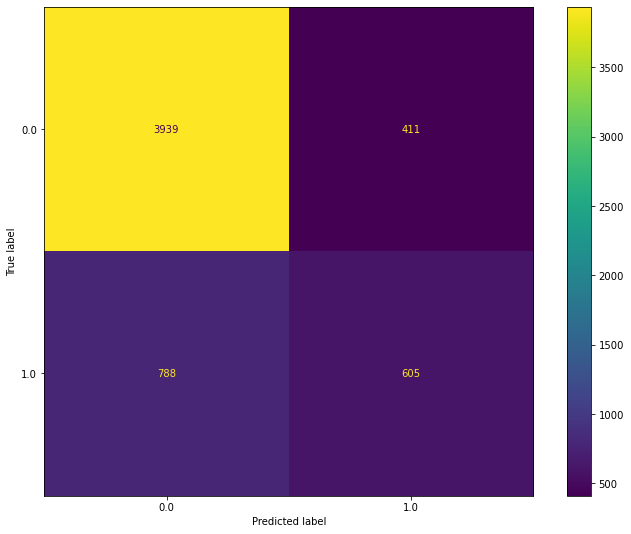




Wersja:  3 	[SVC]
Precyzja :  0.7574438446804805
F1:  0.43099177647874765
[[4350    0]
 [1393    0]]


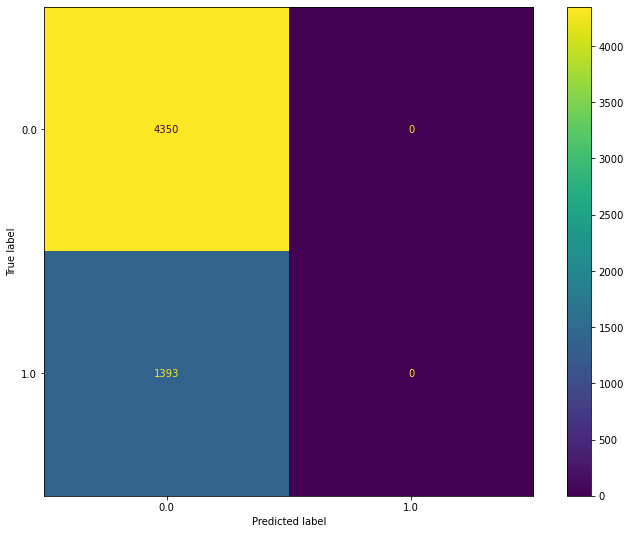

In [16]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split  # Import train_test_split function
from sklearn import metrics  # Import scikit-learn metrics module for accuracy calculation
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay


def naive_bayes_categorical_clasification(cols, targ, ver, feature_cols):
    #scaler_minmax = MinMaxScaler()
    #df_scaled = scaler_minmax.fit_transform(df)
    #df_scaled = pd.DataFrame(data=df_scaled, columns=df.columns)  # "rzutowanie" na pandas dataframe (skalowanie psuje typ)
    
    
    print("Wersja: ", ver, "\t[NB]")

    #X_train, X_test, y_train, y_test = train_test_split(feature_cols, df['target'], 0.3)
    X_train, X_test, y_train, y_test = train_test_split(cols, targ, test_size=0.3, random_state=7)
    
    classifier = CategoricalNB()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test) 
    print ("Precyzja : ", accuracy_score(y_test, y_pred))
    print ("F1: ", f1_score(y_test, y_pred, average='macro'))
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot() 
    plt.show()
    dframe = pd.DataFrame({'Prawdziwe y':y_test, 'Przewidywane y':y_pred})
    #print(dframe)
    
    print("\n\n")
    
    return y_pred


def decision_tree_clasification(cols, targ, ver, feature_cols):
    
    print("Wersja: ", ver, "\t[DT]")
    X_train, X_test, y_train, y_test = train_test_split(cols, targ, test_size=0.3, random_state=7)
    classifier = DecisionTreeClassifier(criterion='gini', max_depth=50, max_features=df.shape[1]-1,
                                               max_leaf_nodes=df.shape[1]-1, random_state=7) #10, 9, 5
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test) 
    print ("accuracy_score : ", accuracy_score(y_test, y_pred))
    print ("F1: ", f1_score(y_test, y_pred, average='macro'))
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot() 
    plt.show()
    dframe = pd.DataFrame({'Prawdziwe y':y_test, 'Przewidywane y':y_pred})
    #print(dframe)
    
    print("\n\n")
    
    return y_pred



def svc_clasification(cols, targ, ver, feature_cols):
    
    #scaler_minmax = MinMaxScaler()
    #df_scaled = scaler_minmax.fit_transform(df)
    #df_scaled = pd.DataFrame(data=df_scaled, columns=df.columns)  # "rzutowanie" na pandas dataframe (skalowanie psuje typ)
    
    
    
    print("Wersja: ", ver, "\t[SVC]")
    X_train, X_test, y_train, y_test = train_test_split(cols, targ, test_size=0.3, random_state=7)
    
    scaler_std = StandardScaler()
    X_train = scaler_std.fit_transform(X_train)  # compute mean, std and transform training data as well
    X_test = scaler_std.transform(X_test)  # same as above
    
    classifier = SVC(kernel='linear', random_state=7)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test) 
    print ("Precyzja : ", accuracy_score(y_test, y_pred))
    print ("F1: ", f1_score(y_test, y_pred, average='macro'))
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot() 
    plt.show()
    dframe = pd.DataFrame({'Prawdziwe y':y_test, 'Przewidywane y':y_pred})
    #print(dframe)
    
    print("\n\n")
    
    return y_pred



df_before_classification = df.copy(deep=True)



for i in [1,2,3]:

    # domyslne wypelnienie brakujacych danych
    if i == 1:
        
        feature_cols = [
        'city_development_index',
        'relevent_experience',
        'enrolled_university',
        'education_level',
        'major_discipline',
        'experience',
        'company_size',
        'last_new_job',
        'training_hours']
        
        df = df_before_classification.copy(deep=True)

        nbc1 = naive_bayes_categorical_clasification(df[feature_cols], df['target'], i, feature_cols)
        df = df_before_classification.copy(deep=True)

        dt1 = decision_tree_clasification(df[feature_cols], df['target'], i, feature_cols)
        df = df_before_classification.copy(deep=True)

        svc1 = svc_clasification(df[feature_cols], df['target'], i, feature_cols)
        df = df_before_classification.copy(deep=True)


    # wersja alternatywna - wypełniamy najpopularniejszym
    elif i == 2:
        
        feature_cols = [
        'city_development_index',
        'relevent_experience',
        'enrolled_university',
        'education_level',
        'major_discipline',
        'experience',
        'company_size',
        'last_new_job',
        'training_hours']
        
        df = df_before_classification.copy(deep=True)
        df['company_size'] = df_not_changed['company_size'] # podstawiam pierwotną kolumnę z wartościami brakującymi
        imp_company_size = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        temp = np.array(df['company_size']).reshape((len(df['company_size']), 1))
        df['company_size'] = imp_company_size.fit_transform(temp)
        cat_company_size = ['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
        oe_company_size = OrdinalEncoder(categories=[cat_company_size])
        df['company_size'] = oe_company_size.fit_transform(df[['company_size']])
        df['company_size'] = df['company_size'] + 1

        
        
        nbc2 = naive_bayes_categorical_clasification(df[feature_cols], df['target'], i,feature_cols)
        
        df = df_before_classification.copy(deep=True)
        df['company_size'] = df_not_changed['company_size'] # podstawiam pierwotną kolumnę z wartościami brakującymi
        imp_company_size = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        temp = np.array(df['company_size']).reshape((len(df['company_size']), 1))
        df['company_size'] = imp_company_size.fit_transform(temp)
        cat_company_size = ['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
        oe_company_size = OrdinalEncoder(categories=[cat_company_size])
        df['company_size'] = oe_company_size.fit_transform(df[['company_size']])
        df['company_size'] = df['company_size'] + 1
        
        
        
        dt2 = decision_tree_clasification(df[feature_cols], df['target'], i, feature_cols)
        
        df = df_before_classification.copy(deep=True)
        df['company_size'] = df_not_changed['company_size'] # podstawiam pierwotną kolumnę z wartościami brakującymi
        imp_company_size = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        temp = np.array(df['company_size']).reshape((len(df['company_size']), 1))
        df['company_size'] = imp_company_size.fit_transform(temp)
        cat_company_size = ['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
        oe_company_size = OrdinalEncoder(categories=[cat_company_size])
        df['company_size'] = oe_company_size.fit_transform(df[['company_size']])
        df['company_size'] = df['company_size'] + 1
        
        
        
        svc2 = svc_clasification(df[feature_cols], df['target'], i, feature_cols)
        df = df_before_classification.copy(deep=True)

    # pomijamy kolumnę
    elif i == 3:
        
        feature_cols = [
        'city_development_index',
        'relevent_experience',
        'enrolled_university',
        'education_level',
        'major_discipline',
        'experience',
        'last_new_job',
        'training_hours']
        
        df = df_before_classification.copy(deep=True)
        df.drop(['company_size'], axis=1, inplace=True)

        nbc3 = naive_bayes_categorical_clasification(df[feature_cols], df['target'], i, feature_cols)
        df = df_before_classification.copy(deep=True)
        df.drop(['company_size'], axis=1, inplace=True)
        
        
        dt3 = decision_tree_clasification(df[feature_cols], df['target'], i, feature_cols)
        df = df_before_classification.copy(deep=True)
        df.drop(['company_size'], axis=1, inplace=True)
        
        
        svc3 = svc_clasification(df[feature_cols], df['target'], i, feature_cols)
        df = df_before_classification.copy(deep=True)


        
df = df_before_classification.copy(deep=True)



Obecność i sposób wypełnienia brakujących wartości w kolumnie 'company_size' nie odgrywa większej roli, zatem usuwamy tę kolumnę z zestawu danych.

Po pierwszych próbach zauważono, że każdy/przynajmniej jeden (w zależności od próby) z klasyfikatorów przewiduje poprawnie jedynie jedną klasę, a drugą w całości błędnie. Można założyć, że z powodu niezbalansowanego datasetu (klasa target: 75% == 0.0 ; 25% == 1.0), model nauczył się klasyfikować próbki do jednej klasy, ponieważ w ten sposób uzyskuje się POZORNIE dobrą skuteczność = 75%). 
Zatem do szkolenia modelu, musimy zmodyfikować wejściowy dataset tak, aby był on zbalansowany (stosunek klas możliwie najbliższy stosunkowi 50:50).

(9548, 8)
(28736, 8)
under
Wersja:  1 	[NB]
Precyzja :  0.5919720767888307
F1:  0.591433707894775
[[900 563]
 [606 796]]


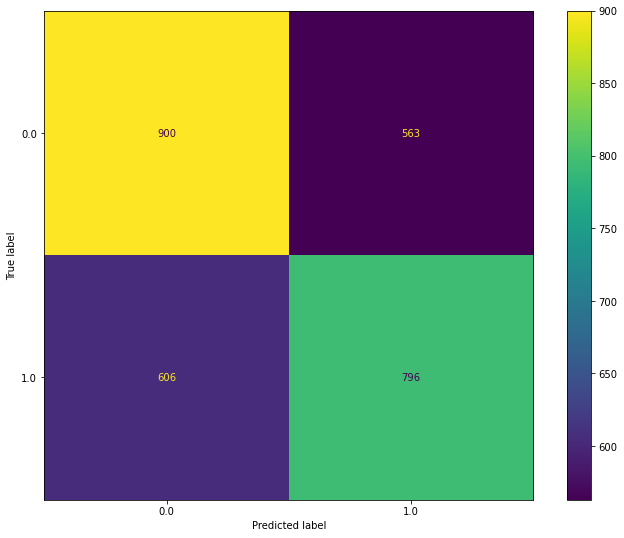




Wersja:  1 	[DT]
accuracy_score :  0.6907504363001745
F1:  0.6881223080416206
[[1121  342]
 [ 544  858]]


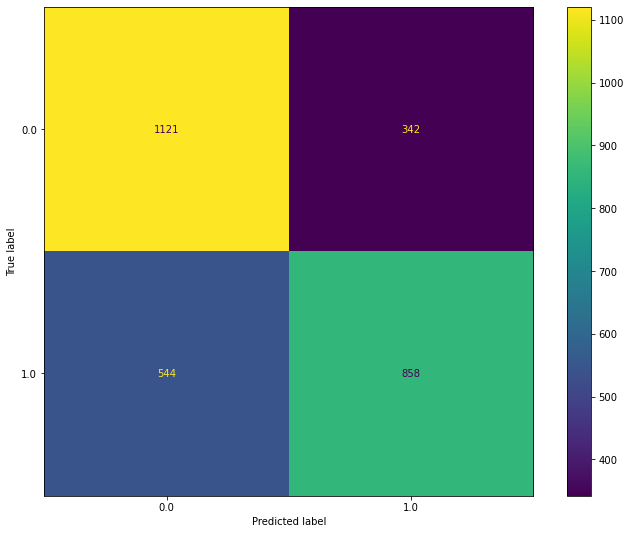




Wersja:  1 	[SVC]
Precyzja :  0.675392670157068
F1:  0.6714206437291899
[[1125  338]
 [ 592  810]]





over
Wersja:  1 	[NB]
Precyzja :  0.6429648532652824
F1:  0.6427083271620132
[[2887 1445]
 [1633 2656]]


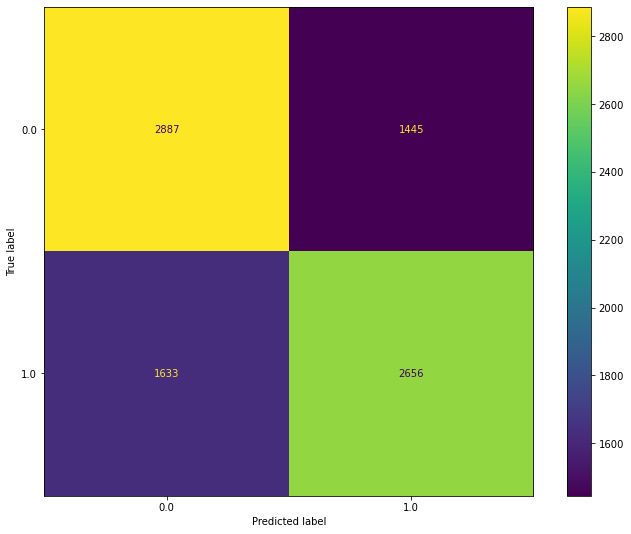




Wersja:  1 	[DT]
accuracy_score :  0.6907504363001745
F1:  0.6881223080416206
[[1121  342]
 [ 544  858]]


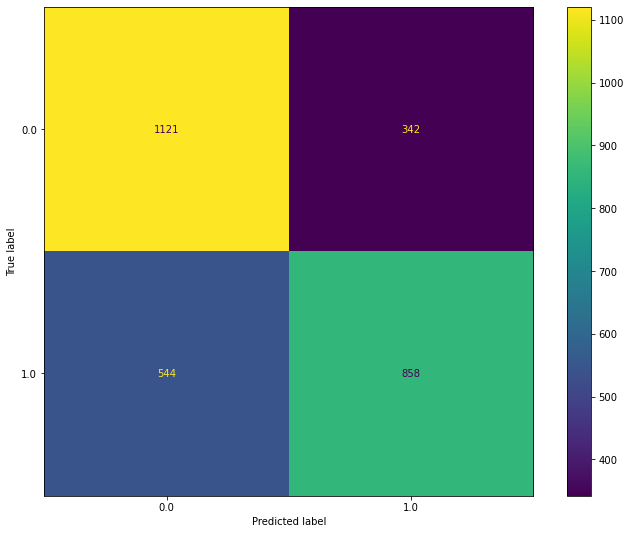




Wersja:  1 	[SVC]
Precyzja :  0.675392670157068
F1:  0.6714206437291899
[[1125  338]
 [ 592  810]]





mix
Wersja:  1 	[NB]
Precyzja :  0.6130828114126653
F1:  0.6125948424335521
[[1398  747]
 [ 921 1245]]


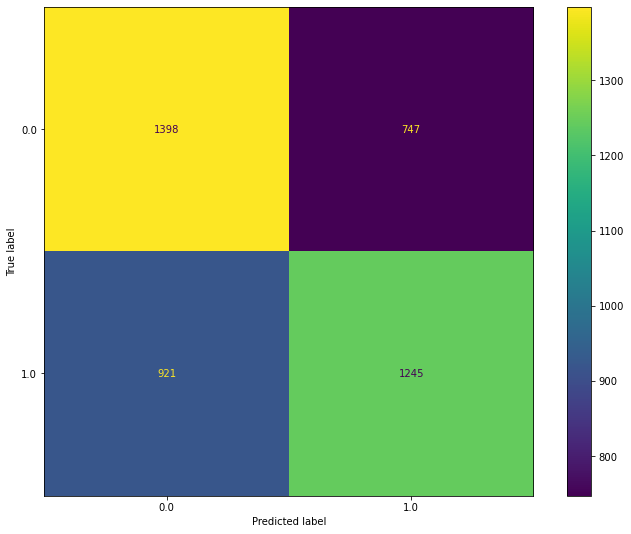




Wersja:  1 	[DT]
accuracy_score :  0.7241939225237763
F1:  0.7214223442717187
[[1776  369]
 [ 820 1346]]


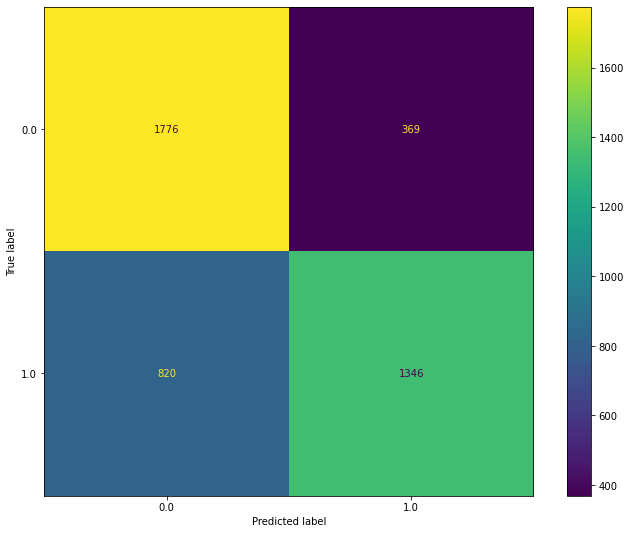




Wersja:  1 	[SVC]
Precyzja :  0.6849918812340524
F1:  0.6826669398587206
[[1661  484]
 [ 874 1292]]


array([0., 0., 0., ..., 1., 1., 0.])

In [17]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

df.drop(['company_size'], axis=1, inplace=True)



feature_cols = [
        'city_development_index',
        'relevent_experience',
        'enrolled_university',
        'education_level',
        'major_discipline',
        'experience',
        'last_new_job',
        'training_hours']

undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(df[feature_cols], df['target'])
print(X_under.shape)

oversample = SMOTE()
#oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(df[feature_cols], df['target'])
print(X_over.shape)



print("under")
naive_bayes_categorical_clasification(X_under, y_under, 1, feature_cols)
decision_tree_clasification(X_under, y_under, 1, feature_cols)
svc_clasification(X_under, y_under, 1, feature_cols)


print("over")
naive_bayes_categorical_clasification(X_over, y_over, 1, feature_cols)
decision_tree_clasification(X_under, y_under, 1, feature_cols)
svc_clasification(X_under, y_under, 1, feature_cols)


print("mix")
oversample = SMOTE(sampling_strategy=0.5)
#oversample = RandomOverSampler(sampling_strategy=0.5)
X_over, y_over = oversample.fit_resample(df[feature_cols], df['target'])
X_under, y_under = undersample.fit_resample(X_over, y_over)
naive_bayes_categorical_clasification(X_under, y_under, 1, feature_cols)
decision_tree_clasification(X_under, y_under, 1, feature_cols)
svc_clasification(X_under, y_under, 1, feature_cols)

Wyżej obliczono, że najlepszy wynik (accuracy_score :  0.7188587334725122 z funkcji accuracy_score) otrzymano dla drzewa decyzyjnego (criterion='gini', max_depth=50, max_features=df.shape[1]-1, max_leaf_nodes=df.shape[1]-1) przy połączeniu techniki oversampling (0.5) i undersampling.

Ponadto, w każdej z grup (samo undersampling, samo oversampling, mix), wyniki drzewa decyzyjnego były wyższe, niż pozostałych dwóch klasyfikatorów.

mix - over:  0.34
Wersja:  1 	[DT]
accuracy_score :  0.691914022517912
F1:  0.6912687270969069
[[1081  400]
 [ 503  947]]





mix - over:  0.4
Wersja:  1 	[DT]
accuracy_score :  0.6964337489127284
F1:  0.6932017364065526
[[1378  385]
 [ 662 1024]]


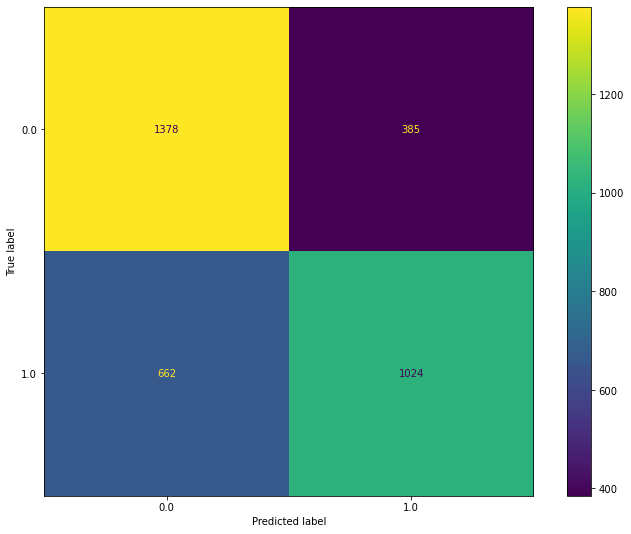




mix - over:  0.5
Wersja:  1 	[DT]
accuracy_score :  0.7088842495940617
F1:  0.7050107452366147
[[1775  370]
 [ 885 1281]]


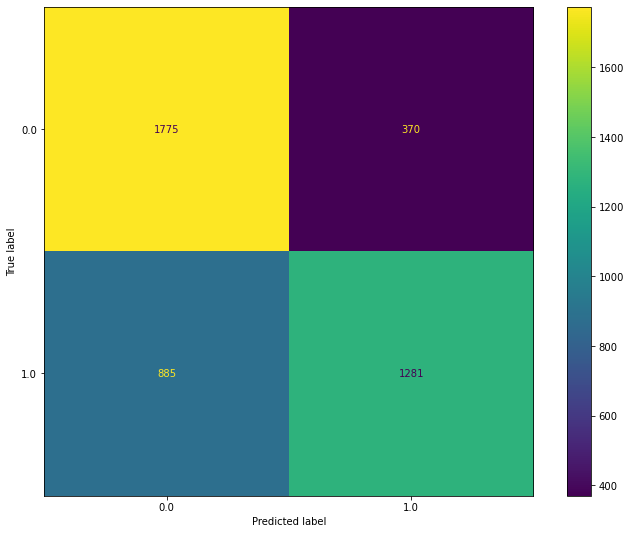




mix - over:  0.6
Wersja:  1 	[DT]
accuracy_score :  0.7267981438515081
F1:  0.7259542850650134
[[2023  543]
 [ 870 1736]]


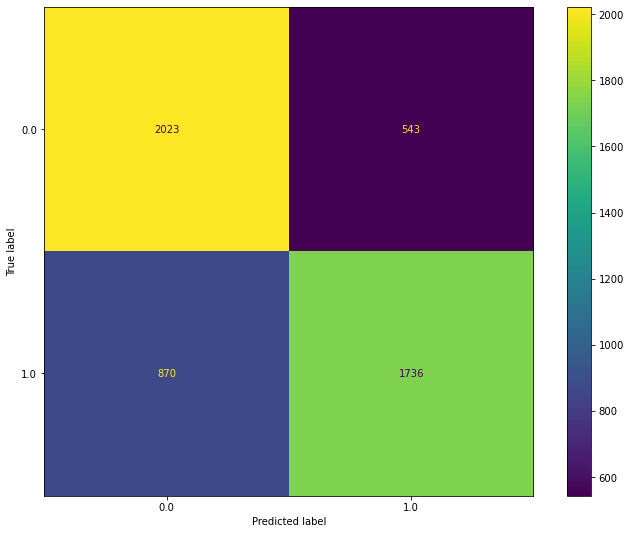




mix - over:  0.7
Wersja:  1 	[DT]
accuracy_score :  0.7330571665285832
F1:  0.7325982965574287
[[2337  636]
 [ 975 2087]]


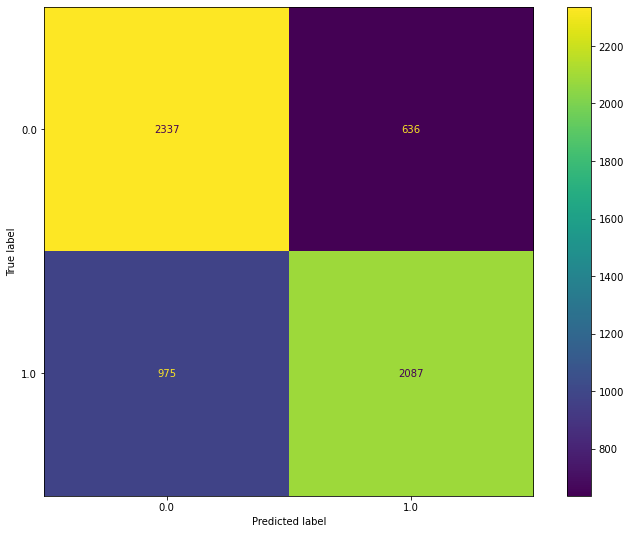




mix - over:  0.8
Wersja:  1 	[DT]
accuracy_score :  0.7219080759750616
F1:  0.7204210450675888
[[2741  611]
 [1307 2238]]


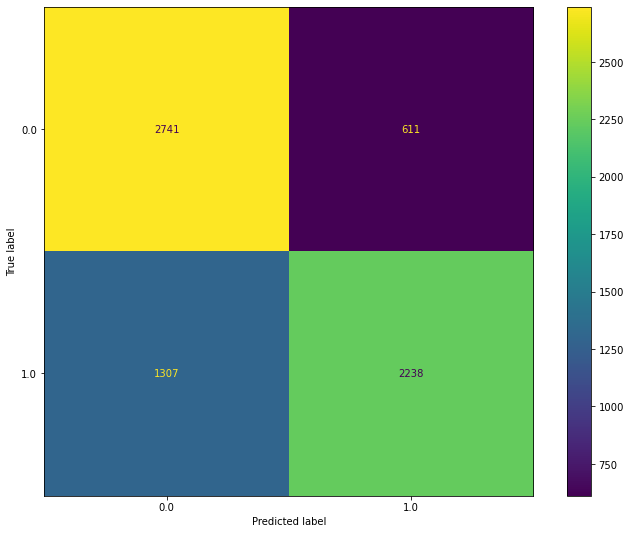




mix - over:  0.9
Wersja:  1 	[DT]
accuracy_score :  0.7125918288439231
F1:  0.708429935976006
[[3228  615]
 [1615 2301]]


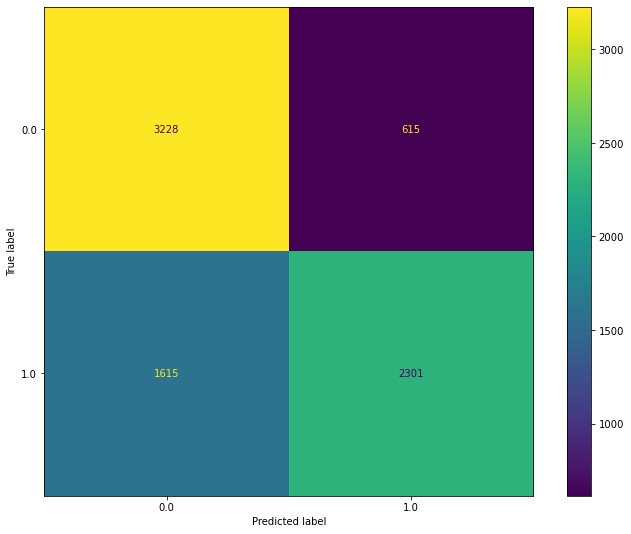




mix - over:  0.91
Wersja:  1 	[DT]
accuracy_score :  0.7125557680050988
F1:  0.7118797549659301
[[2985  892]
 [1363 2605]]


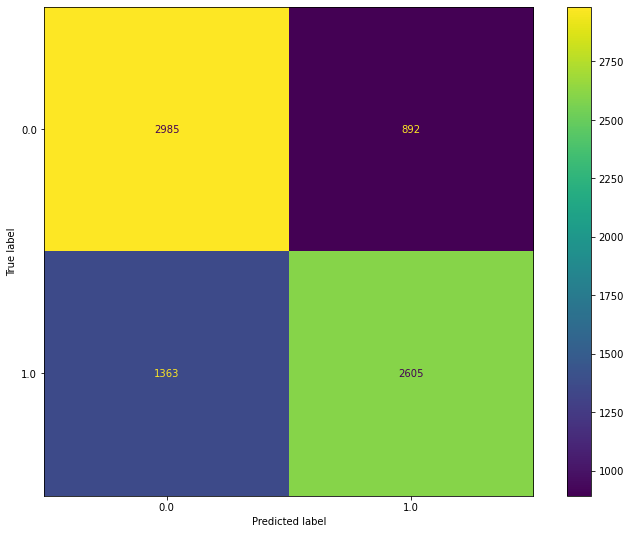




mix - over:  0.92
Wersja:  1 	[DT]
accuracy_score :  0.7251292396923464
F1:  0.7251232571532646
[[2857 1051]
 [1129 2894]]


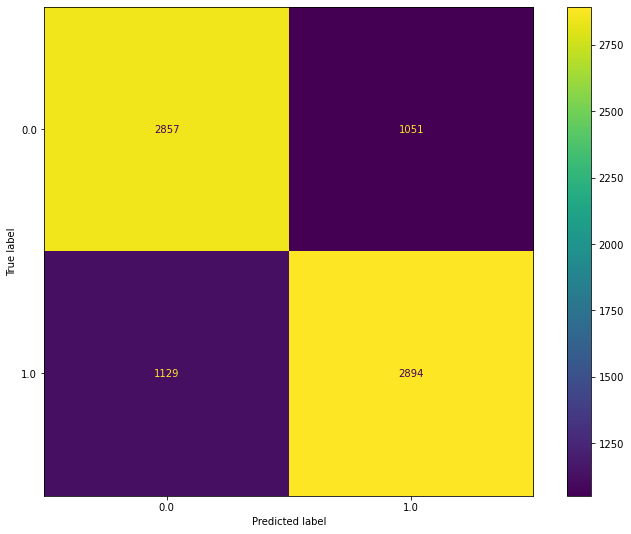




mix - over:  0.93
Wersja:  1 	[DT]
accuracy_score :  0.723497131454228
F1:  0.7221755662464973
[[3177  799]
 [1418 2624]]





mix - over:  0.94
Wersja:  1 	[DT]
accuracy_score :  0.7339257065284462
F1:  0.7336007582970765
[[2832 1210]
 [ 946 3115]]





mix - over:  0.95
Wersja:  1 	[DT]
accuracy_score :  0.7258852258852259
F1:  0.7247542027208639
[[3235  874]
 [1371 2710]]


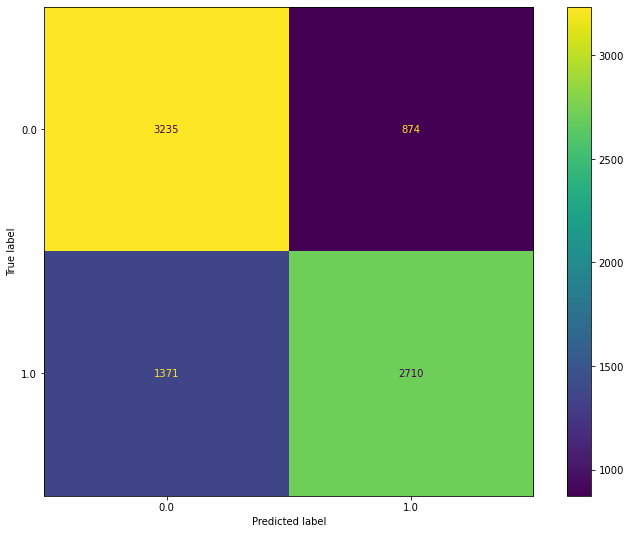




mix - over:  0.96
Wersja:  1 	[DT]
accuracy_score :  0.7327211213146447
F1:  0.7322531323284258
[[2859 1251]
 [ 961 3205]]


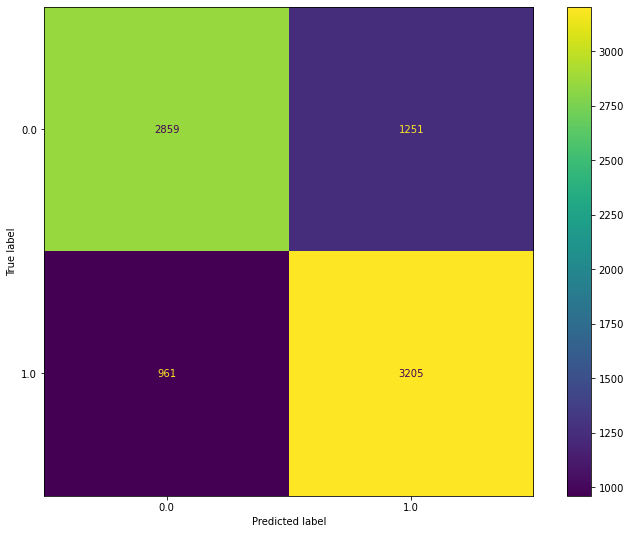




mix - over:  0.97
Wersja:  1 	[DT]
accuracy_score :  0.7311647931116958
F1:  0.73009682285227
[[3320  849]
 [1399 2794]]


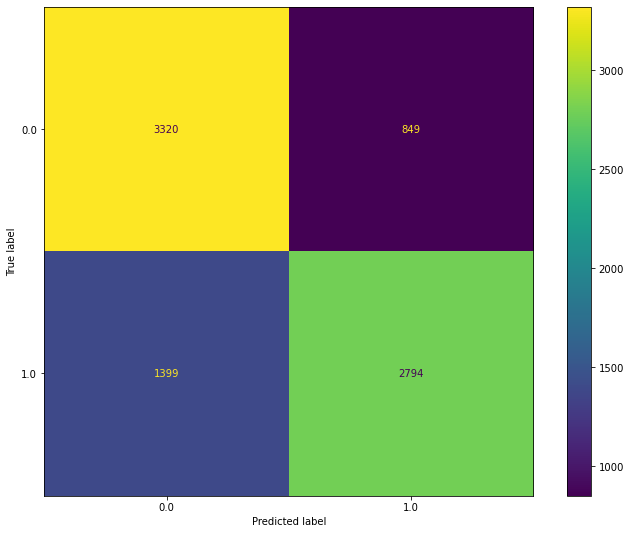




mix - over:  0.98
Wersja:  1 	[DT]
accuracy_score :  0.7320075757575758
F1:  0.7319847281391855
[[3131 1074]
 [1190 3053]]


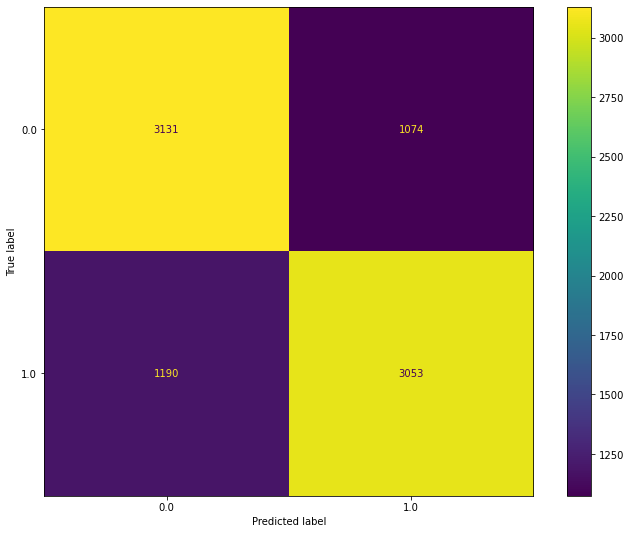




mix - over:  0.99
Wersja:  1 	[DT]
accuracy_score :  0.719859402460457
F1:  0.7190432937459235
[[3302  934]
 [1457 2842]]


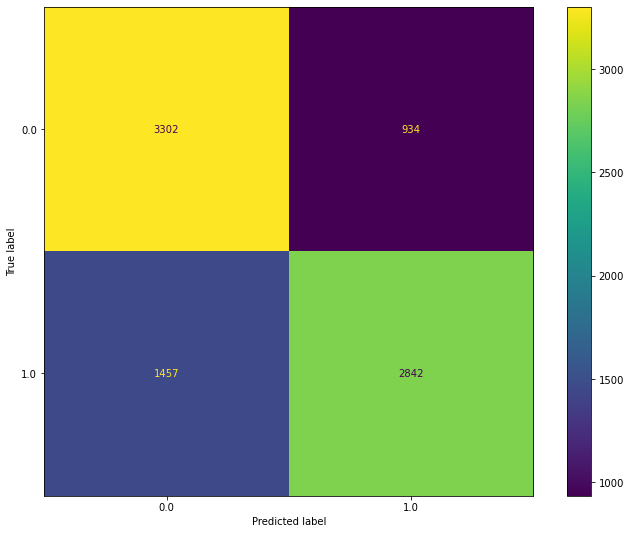

In [18]:
for i in [0.34, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]:

    print("mix - over: ", i)
    oversample = SMOTE(sampling_strategy=i)
    #oversample = RandomOverSampler(sampling_strategy=0.5)
    X_over, y_over = oversample.fit_resample(df[feature_cols], df['target'])
    X_under, y_under = undersample.fit_resample(X_over, y_over)
    decision_tree_clasification(X_under, y_under, 1, feature_cols)

Wybieramy współczynnik oversampling 'sampling_strategy' na poziomie 0.8

## Macierz pomyłek

Dla użytych na ten moment 3 klasyfikatorów obliczymy macierze poomyłek – dla danych niezbalansowanych i po zbalansowaniu danych (stosując metodę, którą wyżej uzyskano najlepsze wyniki: oversampling z parametrem 0.8 a następnie undersampling )

---------------Niezbalansowane dane----------------
[NB]
[[3940  410]
 [1102  291]]




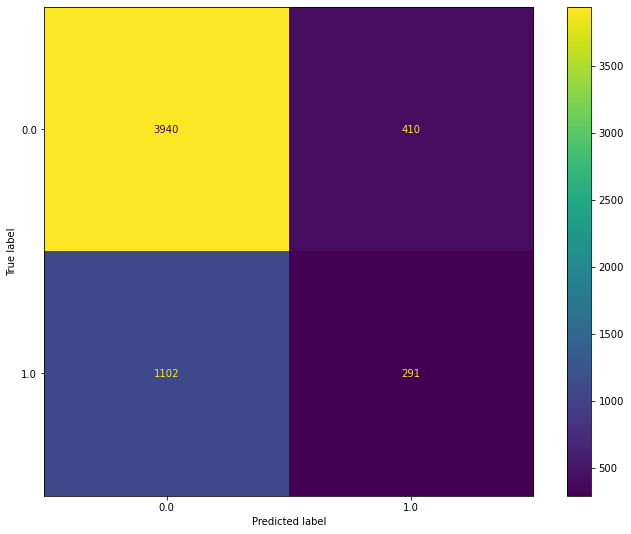

[DT]
[[3939  411]
 [ 788  605]]




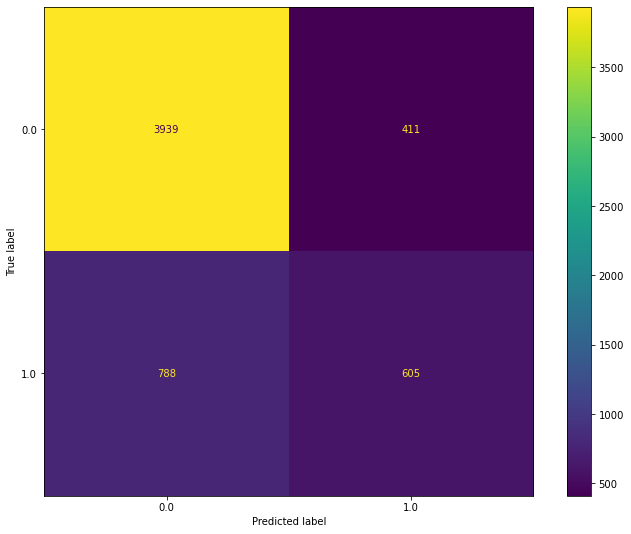

[SVC]
[[4350    0]
 [1393    0]]




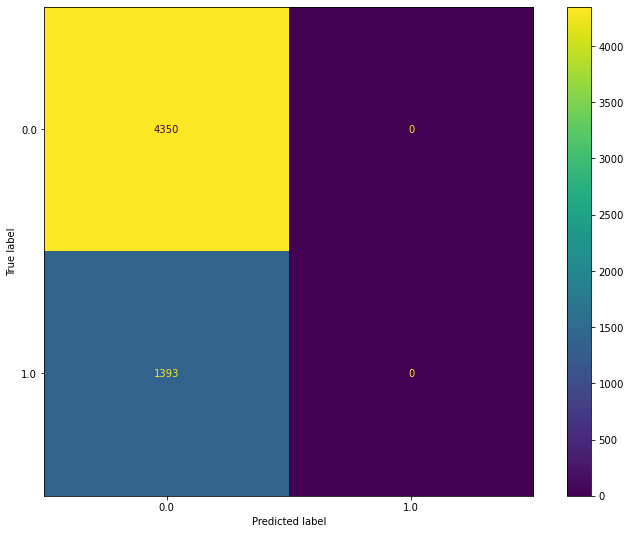

--------------------------------------------------


-----------------Zbalansowane dane----------------
[NB]
[[2245 1107]
 [1462 2083]]




[DT]
[[2410  942]
 [ 865 2680]]




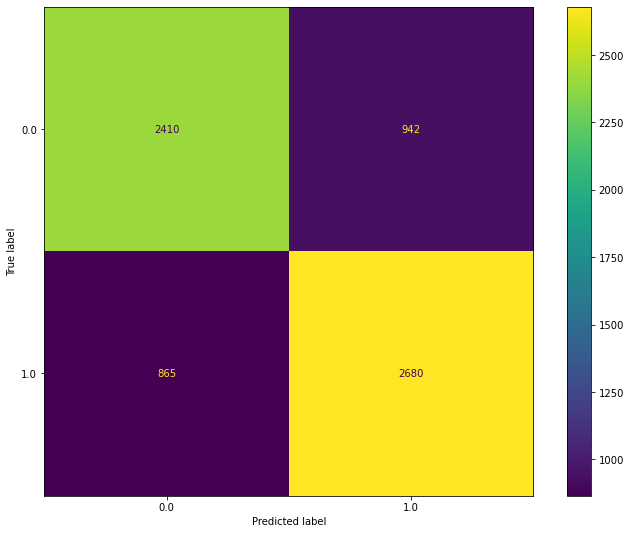

[SVC]
[[2626  726]
 [1525 2020]]




--------------------------------------------------


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#trzeba zmodyfikowac funkcje

def naive_bayes_categorical_clasification(cols, targ, feature_cols):
    print("[NB]")
    X_train, X_test, y_train, y_test = train_test_split(cols, targ, test_size=0.3, random_state=7)
    classifier = CategoricalNB()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test) 
    #print ("Precyzja : ", accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    dframe = pd.DataFrame({'Prawdziwe y':y_test, 'Przewidywane y':y_pred})
    #print(dframe)
    print("\n")
    
    return y_test, y_pred, cm, classifier


def decision_tree_clasification(cols, targ, feature_cols):
    print("[DT]")
    X_train, X_test, y_train, y_test = train_test_split(cols, targ, test_size=0.3, random_state=7)
    classifier = DecisionTreeClassifier(criterion='gini', max_depth=50, max_features=df.shape[1]-1,
                                               max_leaf_nodes=df.shape[1]-1, random_state=7) #10, 9, 5
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test) 
    #print ("accuracy_score : ", accuracy_score(y_test, y_pred))
    #print("score: ", classifier.score(X_train, y_train))
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    dframe = pd.DataFrame({'Prawdziwe y':y_test, 'Przewidywane y':y_pred})
    #print(dframe)
    print("\n")
    
    return y_test, y_pred, cm, classifier



def svc_clasification(cols, targ, feature_cols):
    print("[SVC]")
    X_train, X_test, y_train, y_test = train_test_split(cols, targ, test_size=0.3, random_state=7)
    scaler_std = StandardScaler()
    X_train = scaler_std.fit_transform(X_train)  # compute mean, std and transform training data as well
    X_test = scaler_std.transform(X_test)  # same as above
    classifier = SVC(kernel='linear', random_state=7)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test) 
    #print ("Precyzja : ", accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    dframe = pd.DataFrame({'Prawdziwe y':y_test, 'Przewidywane y':y_pred})
    #print(dframe)
    print("\n")
    
    return y_test, y_pred, cm, classifier


feature_cols = [
        'city_development_index',
        'relevent_experience',
        'enrolled_university',
        'education_level',
        'major_discipline',
        'experience',
        'last_new_job',
        'training_hours']


df_before_classification = df.copy(deep=True)

print("---------------Niezbalansowane dane----------------")
        
[y_true_nb_notbal, y_pred_nb_notbal, cm_nb_notbal, classifier_nb_notbal] = naive_bayes_categorical_clasification(df[feature_cols], df['target'], feature_cols)
disp_nb_notbal = ConfusionMatrixDisplay(confusion_matrix=cm_nb_notbal, display_labels=classifier_nb_notbal.classes_)
disp_nb_notbal.plot()
plt.show()

[y_true_dt_notbal, y_pred_dt_notbal, cm_dt_notbal, classifier_dt_notbal] = decision_tree_clasification(df[feature_cols], df['target'], feature_cols)
disp_dt_notbal = ConfusionMatrixDisplay(confusion_matrix=cm_dt_notbal, display_labels=classifier_dt_notbal.classes_)
disp_dt_notbal.plot() 
plt.show()


[y_true_svc_notbal, y_pred_svc_notbal, cm_svc_notbal, classifier_svc_notbal] = svc_clasification(df[feature_cols], df['target'], feature_cols)
disp_svc_notbal = ConfusionMatrixDisplay(confusion_matrix=cm_svc_notbal, display_labels=classifier_svc_notbal.classes_)
disp_svc_notbal.plot() 
plt.show()


print("--------------------------------------------------\n\n")

print("-----------------Zbalansowane dane----------------")
undersample = RandomUnderSampler(sampling_strategy='majority')
oversample = SMOTE(sampling_strategy=0.8)
X_over, y_over = oversample.fit_resample(df[feature_cols], df['target'])
X_under, y_under = undersample.fit_resample(X_over, y_over)
    
[y_true_nb_bal, y_pred_nb_bal, cm_nb_bal, classifier_nb_bal] = naive_bayes_categorical_clasification(X_under, y_under, feature_cols)
disp_nb_bal = ConfusionMatrixDisplay(confusion_matrix=cm_nb_bal, display_labels=classifier_nb_bal.classes_)
disp_nb_bal.plot() 
plt.show()


[y_true_dt_bal, y_pred_dt_bal, cm_dt_bal, classifier_dt_bal] = decision_tree_clasification(X_under, y_under, feature_cols)
disp_dt_bal = ConfusionMatrixDisplay(confusion_matrix=cm_dt_bal, display_labels=classifier_dt_bal.classes_)
disp_dt_bal.plot() 
plt.show()


[y_true_svc_bal, y_pred_svc_bal, cm_svc_bal, classifier_svc_bal] = svc_clasification(X_under, y_under, feature_cols)
disp_svc_bal = ConfusionMatrixDisplay(confusion_matrix=cm_svc_bal, display_labels=classifier_svc_bal.classes_)
disp_svc_bal.plot() 
plt.show()

print("--------------------------------------------------")



df = df_before_classification.copy(deep=True)


Macierze korelacji klarownie pokazują polepszenie wyników dla danych po zbalansowaniu. Najlepsze proporcje widać przy algorytmie DT (drzewo decyzyjne). Dlatego też w dalszej części notatnika skupimy się bardziej na tym klasyfikatorze.

## Metryki: ACC oraz F1 implementowane samodzielnie + porównanie z gotowymi funkcjami sklearn

Wyniki algorytmów samodzielnie zaimplementowanych i gotowych z biblioteki sklearn są identyczne. Biblioteki sklearn obliczają wskaźniki acc i f1 z tych samych wzorów, jakie użyto do samodzielnej implementacji.

In [20]:
from sklearn.metrics import accuracy_score, f1_score

def acc(tp, tn, fp, fn):
    return ((tp + tn)/(tp + tn + fp + fn))

def f1(tp, tn, fp, fn):
    a = (2 * tp / ((2 * tp) + fp + fn))
    b = (2 * tn / ((2 * tn) + fp + fn))
    return (a + b) / 2
    #return (((2*tp)/(2*tp + fp + fn))  /  2)
    #return (tp / (tp + (fp + fn)/2))
    



print("---------------Niezbalansowane dane----------------")
        
print("NB")
accuracy_nb_notbal = acc(cm_nb_notbal[1,1], cm_nb_notbal[0,0], cm_nb_notbal[0,1], cm_nb_notbal[1,0])
print("Accuracy: \t\t", accuracy_nb_notbal)
accuracy_nb_notbal_sklearn = accuracy_score(y_true_nb_notbal, y_pred_nb_notbal)
print("Accuracy score sklearn: ", accuracy_nb_notbal_sklearn)

f1_nb_notbal = f1(cm_nb_notbal[1,1], cm_nb_notbal[0,0], cm_nb_notbal[0,1], cm_nb_notbal[1,0])
print("F1: \t\t\t", f1_nb_notbal)
f1_nb_notbal_sklearn = f1_score(y_true_nb_notbal, y_pred_nb_notbal, average='macro')
print("F1 score sklearn: \t", f1_nb_notbal_sklearn)



print("\n\nDT")
accuracy_dt_notbal = acc(cm_dt_notbal[1,1], cm_dt_notbal[0,0], cm_dt_notbal[0,1], cm_dt_notbal[1,0])
print("Accuracy: \t\t", accuracy_dt_notbal)
accuracy_dt_notbal_sklearn = accuracy_score(y_true_dt_notbal, y_pred_dt_notbal)
print("Accuracy score sklearn: ", accuracy_dt_notbal_sklearn)

f1_dt_notbal = f1(cm_dt_notbal[1,1], cm_dt_notbal[0,0], cm_dt_notbal[0,1], cm_dt_notbal[1,0])
print("F1: \t\t\t", f1_dt_notbal)
f1_dt_notbal_sklearn = f1_score(y_true_dt_notbal, y_pred_dt_notbal, average='macro')
print("F1 score sklearn: \t", f1_dt_notbal_sklearn)



print("\n\nSVC")
accuracy_svc_notbal = acc(cm_svc_notbal[1,1], cm_svc_notbal[0,0], cm_svc_notbal[0,1], cm_svc_notbal[1,0])
print("Accuracy: \t\t", accuracy_svc_notbal)
accuracy_svc_notbal_sklearn = accuracy_score(y_true_svc_notbal, y_pred_svc_notbal)
print("Accuracy score sklearn: ", accuracy_svc_notbal_sklearn)

f1_svc_notbal = f1(cm_svc_notbal[1,1], cm_svc_notbal[0,0], cm_svc_notbal[0,1], cm_svc_notbal[1,0])
print("F1: \t\t\t", f1_svc_notbal)
f1_svc_notbal_sklearn = f1_score(y_true_svc_notbal, y_pred_svc_notbal, average='macro')
print("F1 score sklearn: \t", f1_svc_notbal_sklearn)


print("--------------------------------------------------\n\n")




print("-----------------Zbalansowane dane----------------")

print("NB")
accuracy_nb_bal = acc(cm_nb_bal[1,1], cm_nb_bal[0,0], cm_nb_bal[0,1], cm_nb_bal[1,0])
print("Accuracy: \t\t", accuracy_nb_bal)
accuracy_nb_bal_sklearn = accuracy_score(y_true_nb_bal, y_pred_nb_bal)
print("Accuracy score sklearn: ", accuracy_nb_bal_sklearn)

f1_nb_bal = f1(cm_nb_bal[1,1], cm_nb_bal[0,0], cm_nb_bal[0,1], cm_nb_bal[1,0])
print("F1: \t\t\t", f1_nb_bal)
f1_nb_bal_sklearn = f1_score(y_true_nb_bal, y_pred_nb_bal, average='macro')
print("F1 score sklearn: \t", f1_nb_bal_sklearn)



print("\n\nDT")
accuracy_dt_bal = acc(cm_dt_bal[1,1], cm_dt_bal[0,0], cm_dt_bal[0,1], cm_dt_bal[1,0])
print("Accuracy: \t\t", accuracy_dt_bal)
accuracy_dt_bal_sklearn = accuracy_score(y_true_dt_bal, y_pred_dt_bal)
print("Accuracy score sklearn: ", accuracy_dt_bal_sklearn)

f1_dt_bal = f1(cm_dt_bal[1,1], cm_dt_bal[0,0], cm_dt_bal[0,1], cm_dt_bal[1,0])
print("F1: \t\t\t", f1_dt_bal)
f1_dt_bal_sklearn = f1_score(y_true_dt_bal, y_pred_dt_bal, average='macro')
print("F1 score sklearn: \t", f1_dt_bal_sklearn)



print("\n\nSVC")
accuracy_svc_bal = acc(cm_svc_bal[1,1], cm_svc_bal[0,0], cm_svc_bal[0,1], cm_svc_bal[1,0])
print("Accuracy: \t\t", accuracy_svc_bal)
accuracy_svc_bal_sklearn = accuracy_score(y_true_svc_bal, y_pred_svc_bal)
print("Accuracy score sklearn: ", accuracy_svc_bal_sklearn)

f1_svc_bal = f1(cm_svc_bal[1,1], cm_svc_bal[0,0], cm_svc_bal[0,1], cm_svc_bal[1,0])
print("F1: \t\t\t", f1_svc_bal)
f1_svc_bal_sklearn = f1_score(y_true_svc_bal, y_pred_svc_bal, average='macro')
print("F1 score sklearn: \t", f1_svc_bal_sklearn)


print("--------------------------------------------------\n\n")




---------------Niezbalansowane dane----------------
NB
Accuracy: 		 0.7367229670903709
Accuracy score sklearn:  0.7367229670903709
F1: 			 0.5584744438966529
F1 score sklearn: 	 0.5584744438966529


DT
Accuracy: 		 0.7912240989030124
Accuracy score sklearn:  0.7912240989030124
F1: 			 0.685095502054216
F1 score sklearn: 	 0.685095502054216


SVC
Accuracy: 		 0.7574438446804805
Accuracy score sklearn:  0.7574438446804805
F1: 			 0.43099177647874765
F1 score sklearn: 	 0.43099177647874765
--------------------------------------------------


-----------------Zbalansowane dane----------------
NB
Accuracy: 		 0.6275192112512686
Accuracy score sklearn:  0.6275192112512686
F1: 			 0.6273135970412915
F1 score sklearn: 	 0.6273135970412915


DT
Accuracy: 		 0.7380020298680586
Accuracy score sklearn:  0.7380020298680586
F1: 			 0.7375998956032006
F1 score sklearn: 	 0.7375998956032008


SVC
Accuracy: 		 0.6736262142960707
Accuracy score sklearn:  0.6736262142960707
F1: 			 0.6710869618135896
F1 

Widzimy, że wyniki parami są równe - są to pary wyników obliczonych własnoręcznie oraz za pomocą gotowej biblioteki. Miarą F1 z biblioteki sklearn, która odpowiada naszemu implementowanemu algorytmowi jest dokładnie F1_macro, i tejże funkcji będziemy używać w dalszych krokach.

Wyniki 'accuracy score' i F1 różnią się najbardziej w grupie danych przed zbalansowaniem, ponieważ w tej grupie klasyfikatory działają na korzyść klasy, która ma zdecydowanie większy udział w rekordach. 

Obserwujemy, że miary 'accuracy score' dają złudnie optymistyczne wyniki, ponieważ nie biorą pod uwagę błędnie zaklasyfikowanych próbek, tak jak robi to algorytm F1. Miara F1 jest bardziej holistyczna i bardziej zgodna z naszym pojęciem dobrze działającego klasyfikatora, dlatego to ten wskaźnik będzie nam służył do określenia na końcu tej pracy, który z klasyfikatorów i pod jakimi warunkami sprawdził się lepiej dla naszego problemu.



## Kolejne dwa klasyfikatory - dopełnienie do wymaganych pięciu
### Random forest
### Nearest neighbors

---------------Niezbalansowane dane----------------
RF
[RF]
[[3832  518]
 [ 903  490]]


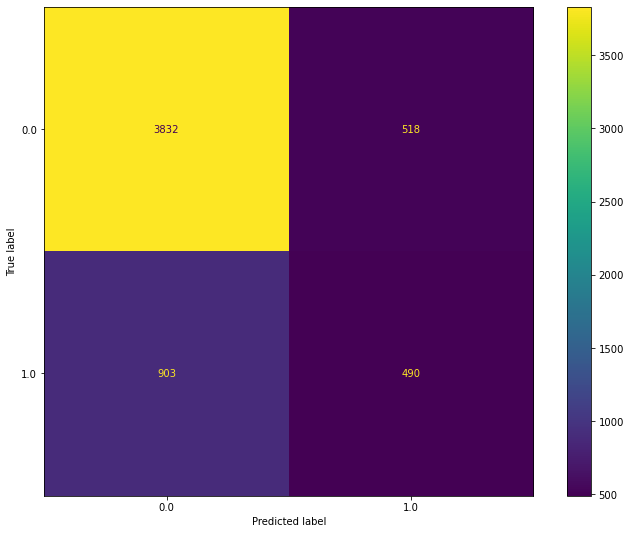



Accuracy score sklearn:  0.752568344071043
F1 score sklearn: 	 0.6258757988610965


NN
[NN]
[[3722  628]
 [1047  346]]




Accuracy score sklearn:  0.7083405885425735
F1 score sklearn: 	 0.5543353841867329
--------------------------------------------------


-----------------Zbalansowane dane----------------
RF
[RF]
[[2762  590]
 [ 886 2659]]


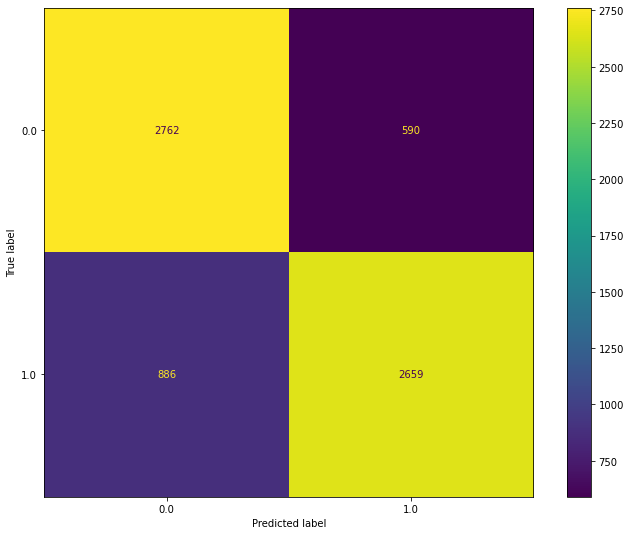



Accuracy score sklearn:  0.7859939103958242
F1 score sklearn: 	 0.7859461709912107


NN
[NN]
[[2032 1320]
 [ 772 2773]]




Accuracy score sklearn:  0.6966797158184718
F1 score sklearn: 	 0.693137625711598
--------------------------------------------------




In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier



def random_forest_clasification(cols, targ, feature_cols):
    print("[RF]")
    X_train, X_test, y_train, y_test = train_test_split(cols, targ, test_size=0.3, random_state=7)
    classifier = RandomForestClassifier(criterion='gini', max_depth=50, max_features=None, n_jobs=-1, random_state=7)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test) 
    #print ("Precyzja : ", accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot() 
    plt.show()
    #dframe = pd.DataFrame({'Prawdziwe y':y_test, 'Przewidywane y':y_pred})
    #print(dframe)
    print("\n")
    
    return y_test, y_pred, cm, classifier


def nearest_neighbors_clasification(cols, targ, feature_cols):
    print("[NN]")
    X_train, X_test, y_train, y_test = train_test_split(cols, targ, test_size=0.3, random_state=7)
    classifier = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test) 
    #print ("Precyzja : ", accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot() 
    plt.show()
    dframe = pd.DataFrame({'Prawdziwe y':y_test, 'Przewidywane y':y_pred})
    #print(dframe)
    print("\n")
    
    return y_test, y_pred, cm, classifier


        





print("---------------Niezbalansowane dane----------------")
        
print("RF")
[y_true_rf_notbal, y_pred_rf_notbal, cm_rf_notbal, classifier_rf_notbal] = random_forest_clasification(df[feature_cols], df['target'], feature_cols)
accuracy_rf_notbal_sklearn = accuracy_score(y_true_rf_notbal, y_pred_rf_notbal)
print("Accuracy score sklearn: ", accuracy_rf_notbal_sklearn)
f1_rf_notbal_sklearn = f1_score(y_true_rf_notbal, y_pred_rf_notbal, average='macro')
print("F1 score sklearn: \t", f1_rf_notbal_sklearn)


print("\n\nNN")
[y_true_nn_notbal, y_pred_nn_notbal, cm_nn_notbal, classifier_nn_notbal] = nearest_neighbors_clasification(df[feature_cols], df['target'], feature_cols)
accuracy_nn_notbal_sklearn = accuracy_score(y_true_nn_notbal, y_pred_nn_notbal)
print("Accuracy score sklearn: ", accuracy_nn_notbal_sklearn)
f1_nn_notbal_sklearn = f1_score(y_true_nn_notbal, y_pred_nn_notbal, average='macro')
print("F1 score sklearn: \t", f1_nn_notbal_sklearn)

print("--------------------------------------------------\n\n")




print("-----------------Zbalansowane dane----------------")

print("RF")
[y_true_rf_bal, y_pred_rf_bal, cm_rf_bal, classifier_rf_bal] = random_forest_clasification(X_under, y_under, feature_cols)
accuracy_rf_bal_sklearn = accuracy_score(y_true_rf_bal, y_pred_rf_bal)
print("Accuracy score sklearn: ", accuracy_rf_bal_sklearn)
f1_rf_bal_sklearn = f1_score(y_true_rf_bal, y_pred_rf_bal, average='macro')
print("F1 score sklearn: \t", f1_rf_bal_sklearn)


print("\n\nNN")
[y_true_nn_bal, y_pred_nn_bal, cm_nn_bal, classifier_nn_bal] = nearest_neighbors_clasification(X_under, y_under, feature_cols)
accuracy_nn_bal_sklearn = accuracy_score(y_true_nn_bal, y_pred_nn_bal)
print("Accuracy score sklearn: ", accuracy_nn_bal_sklearn)
f1_nn_bal_sklearn = f1_score(y_true_nn_bal, y_pred_nn_bal, average='macro')
print("F1 score sklearn: \t", f1_nn_bal_sklearn)

print("--------------------------------------------------\n\n")


## Granice decyzyjne / schematy

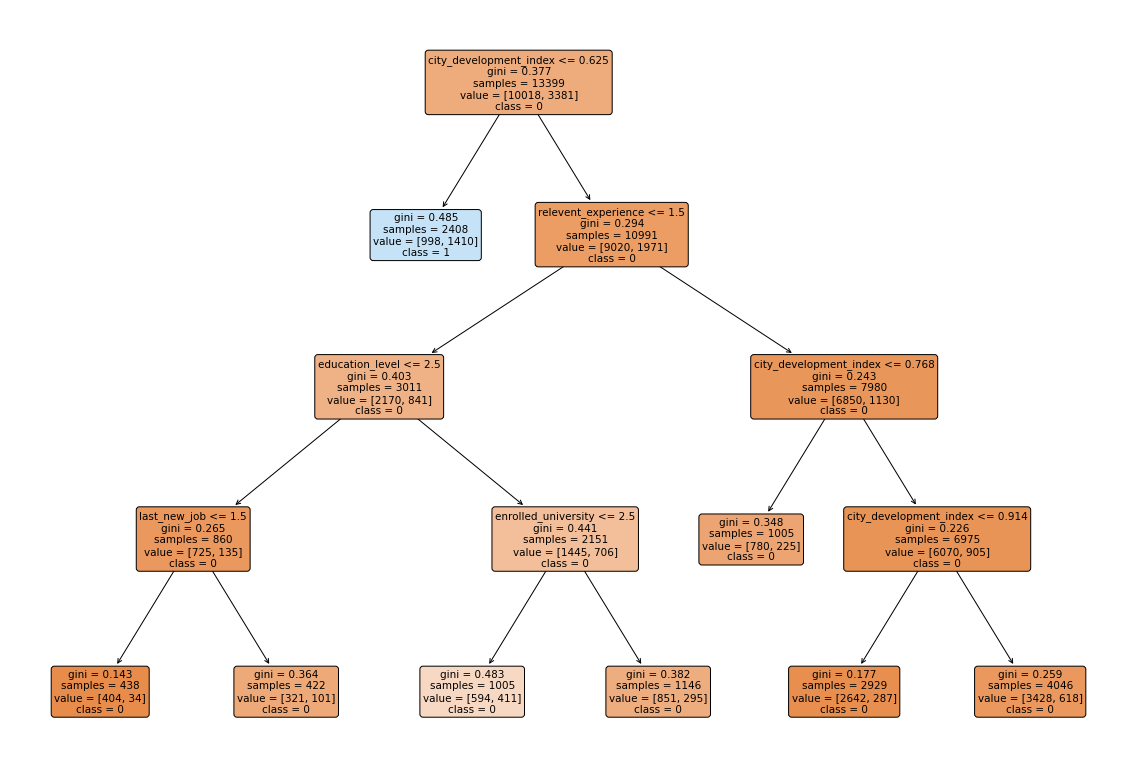

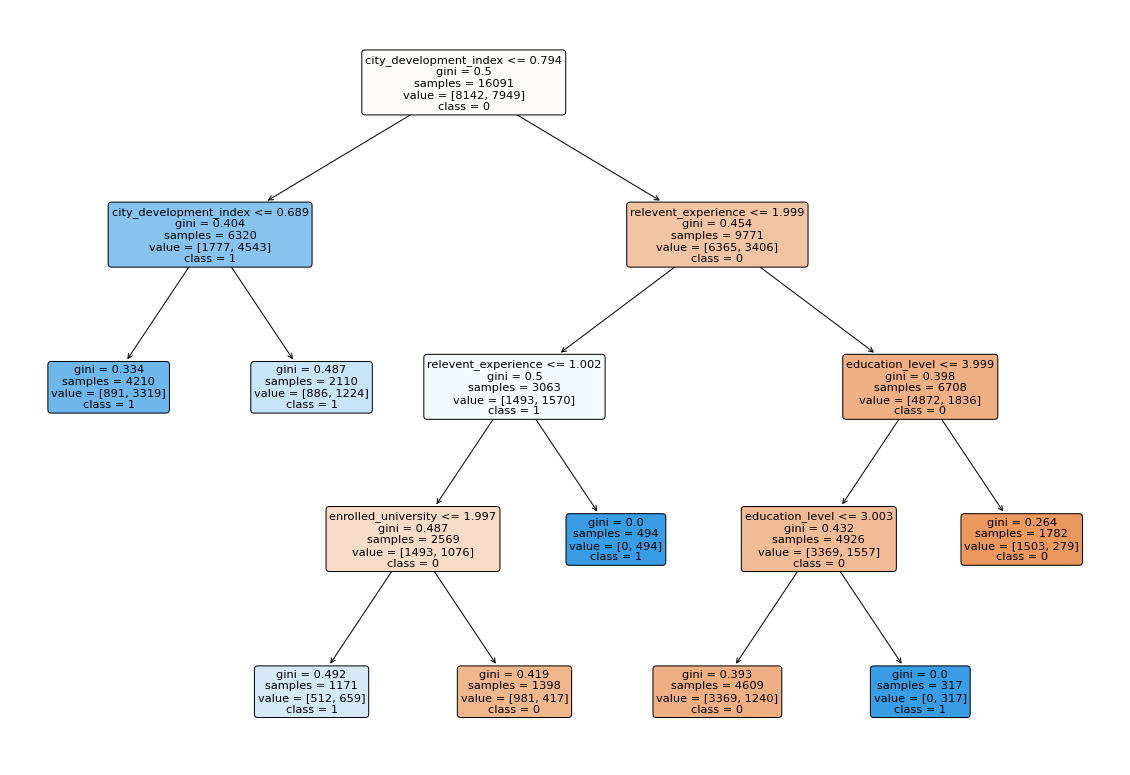

In [22]:
import matplotlib.pyplot as plt
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from matplotlib import colors


#---------------------------- Decision Tree unbalanced-----------------------------------
plt.figure(figsize=(20, 14))

plot_tree(classifier_dt_notbal, 
          filled=True, 
          rounded=True,
          class_names=['0', '1'],
          feature_names=feature_cols) 

plt.show()



#---------------------------- Decision Tree balanced -----------------------------------
plt.figure(figsize=(20, 14))

plot_tree(classifier_dt_bal, 
          filled=True, 
          rounded=True,
          class_names=['0', '1'],
          feature_names=feature_cols) 

plt.show()



## K-krotna walidacja krzyżowa

In [23]:
# Modyfikacja funkcji



def naive_bayes_categorical_clasification(X_train, X_test, y_train, y_test):

    #print("[NB]")

    #X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['target'], test_size=0.3, random_state=7)
    classifier = CategoricalNB()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    #print("Precyzja : ", accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    #dframe = pd.DataFrame({'Prawdziwe y': y_test, 'Przewidywane y': y_pred})
    #print(dframe)
    #print("\n\n")

    return y_test, y_pred, cm, classifier



def decision_tree_clasification(X_train, X_test, y_train, y_test):
    #print("[DT]")
    #X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['target'], test_size=0.3, random_state=7)
    classifier = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features=X_train.shape[1]-1,
                                        max_leaf_nodes=5, random_state=7)  # 10, 9, 5
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    #print("Precyzja : ", accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    #dframe = pd.DataFrame({'Prawdziwe y': y_test, 'Przewidywane y': y_pred})
    #print(dframe)
    #print("\n\n")

    return y_test, y_pred, cm, classifier


def svc_clasification(X_train, X_test, y_train, y_test):
    #print("[SVC]")
    #X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['target'], test_size=0.3, random_state=7)
    scaler_std = StandardScaler()
    X_train = scaler_std.fit_transform(X_train)  # compute mean, std and transform training data as well
    X_test = scaler_std.transform(X_test)  # same as above
    classifier = SVC(kernel='linear', random_state=7)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    #print("Precyzja : ", accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    #dframe = pd.DataFrame({'Prawdziwe y': y_test, 'Przewidywane y': y_pred})
    #print(dframe)
    #print("\n\n")

    return y_test, y_pred, cm, classifier




def random_forest_clasification(X_train, X_test, y_train, y_test):
    #print("[RF]")
    #X_train, X_test, y_train, y_test = train_test_split(cols, targ, test_size=0.3, random_state=7)
    classifier = RandomForestClassifier(criterion='gini', max_depth=50, max_features=None, n_jobs=-1, random_state=7)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    # print ("Precyzja : ", accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    # dframe = pd.DataFrame({'Prawdziwe y':y_test, 'Przewidywane y':y_pred})
    # print(dframe)
    #print("\n")

    return y_test, y_pred, cm, classifier


def nearest_neighbors_clasification(X_train, X_test, y_train, y_test):
    #print("[NN]")
    #X_train, X_test, y_train, y_test = train_test_split(cols, targ, test_size=0.3, random_state=7)
    classifier = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    # print ("Precyzja : ", accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    #dframe = pd.DataFrame({'Prawdziwe y': y_test, 'Przewidywane y': y_pred})
    # print(dframe)
    #print("\n")

    return y_test, y_pred, cm, classifier



In [24]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from math import ceil, floor

# po deletach pozostają stare indexy z brakującymi wartościami. Ustawiamy nowe, ciągłe indeksowanie.
df.reset_index(drop=True, inplace=True)

feature_cols = [
    'city_development_index',
    'relevent_experience',
    'enrolled_university',
    'education_level',
    'major_discipline',
    'experience',
    'last_new_job',
    'training_hours']


def k_cross(cols, targ, indexes, to_print):
    #to_print = ['NB', 'DT', 'SVC', 'RF', 'NN']
    #to_print = ['NN']

    k = len(indexes)
    X = []
    y = []
    # ----------- podział (slicing) --------
    for i in range(0, k - 1):
        X.append(cols.iloc[indexes[i]:indexes[i + 1]])
        y.append(targ.iloc[indexes[i]:indexes[i + 1]])

    X.append(cols.iloc[indexes[k - 1]:])
    y.append(targ.iloc[indexes[k - 1]:])
    # --------------------------------------

    NB_av_acc = 0
    NB_av_f1 = 0
    DT_av_acc = 0
    DT_av_f1 = 0
    SVC_av_acc = 0
    SVC_av_f1 = 0
    RF_av_acc = 0
    RF_av_f1 = 0
    NN_av_acc = 0
    NN_av_f1 = 0

    # ----------- "k" modeli ---------------
    for i in range(0, k):
        X_train = pd.DataFrame(columns=feature_cols)
        X_test = pd.DataFrame(columns=feature_cols)
        y_train = []
        y_test = []
        #    ------- wypełnianie   ---------
        for j in range(0, len(y)):
            if i == j:
                X_test = X_test.append(X[j], ignore_index=True)
                y_test.append(y[j])
            else:
                X_train = X_train.append(X[j], ignore_index=True)
                y_train.append(y[j])

        y_test = np.array(y_test).reshape(X_test.shape[0], ) # ma byc list[X_test.shape[0], 1]
        y_train = list(np.concatenate(y_train).flat) # wypłaszczanie listy zagnieżdżonej
        y_train = np.array(y_train).reshape(X_train.shape[0], )

        if 'NB' in to_print:
            [y_true_nb, y_pred_nb, cm_nb, classifier_nb] = naive_bayes_categorical_clasification(X_train, X_test, y_train, y_test)
            accuracy_nb = accuracy_score(y_true_nb, y_pred_nb)
            f1_nb = f1_score(y_true_nb, y_pred_nb, average='macro')
            print("NB \titer: ", i, " \tacc = \t", accuracy_nb, " \tF1 = \t", f1_nb)
            NB_av_acc += accuracy_nb
            NB_av_f1 += f1_nb
        if 'DT' in to_print:
            [y_true_dt, y_pred_dt, cm_dt, classifier_dt] = decision_tree_clasification(X_train, X_test, y_train, y_test)
            accuracy_dt = accuracy_score(y_true_dt, y_pred_dt)
            f1_dt = f1_score(y_true_dt, y_pred_dt, average='macro')
            print("DT \titer: ", i, " \tacc = \t", accuracy_dt, " \tF1 = \t", f1_dt)
            DT_av_acc += accuracy_dt
            DT_av_f1 += f1_dt
        if 'SVC' in to_print:
            [y_true_svc, y_pred_svc, cm_svc, classifier_svc] = svc_clasification(X_train, X_test, y_train, y_test)
            accuracy_svc = accuracy_score(y_true_svc, y_pred_svc)
            f1_svc = f1_score(y_true_svc, y_pred_svc, average='macro')
            print("SVC \titer: ", i, " \tacc = \t", accuracy_svc, " \tF1 = \t", f1_svc)
            SVC_av_acc += accuracy_svc
            SVC_av_f1 += f1_svc
        if 'RF' in to_print:
            [y_true_rf, y_pred_rf, cm_rf, classifier_rf] = random_forest_clasification(X_train, X_test, y_train, y_test)
            accuracy_rf = accuracy_score(y_true_rf, y_pred_rf)
            f1_rf = f1_score(y_true_rf, y_pred_rf, average='macro')
            print("RF \titer: ", i, " \tacc = \t", accuracy_rf, " \tF1 = \t", f1_rf)
            RF_av_acc += accuracy_rf
            RF_av_f1 += f1_rf
        if 'NN' in to_print:
            [y_true_nn, y_pred_nn, cm_nn, classifier_nn] = nearest_neighbors_clasification(X_train, X_test, y_train, y_test)
            accuracy_nn = accuracy_score(y_true_nn, y_pred_nn)
            f1_nn = f1_score(y_true_nn, y_pred_nn, average='macro')
            print("NN \titer: ", i, " \tacc = \t", accuracy_nn, " \tF1 = \t", f1_nn)
            NN_av_acc += accuracy_nn
            NN_av_f1 += f1_nn

    if 'NB' in to_print:
        NB_av_acc /= k
        NB_av_f1 /= k
        print("\nNB Average \tacc = \t", NB_av_acc, "\tF1 = \t", NB_av_f1)
    if 'DT' in to_print:
        DT_av_acc /= k
        DT_av_f1 /= k
        print("\nDT Average \tacc = \t", DT_av_acc, "\tF1 = \t", DT_av_f1)
    if 'SVC' in to_print:
        SVC_av_acc /= k
        SVC_av_f1 /= k
        print("\nSVC Average \tacc = \t", SVC_av_acc, "\tF1 = \t", SVC_av_f1)
    if 'RF' in to_print:
        RF_av_acc /= k
        RF_av_f1 /= k
        print("\nRF Average \tacc = \t", RF_av_acc, "\tF1 = \t", RF_av_f1)
    if 'NN' in to_print:
        NN_av_acc /= k
        NN_av_f1 /= k
        print("\nNN Average \tacc = \t", NN_av_acc, "\tF1 = \t", NN_av_f1)



lista_klasyfikatorow = ['NB', 'DT', 'SVC', 'RF', 'NN']
k = 10

# ----------------------------------- Zbiór niezbalansowany -------------------------------------------------
print(" ----------------------------------- Zbiór niezbalansowany -------------------------------------------------")
num_of_records_notbal = df['target'].count()
index_step = floor(num_of_records_notbal / k)
indexes = np.arange(0, num_of_records_notbal - index_step, index_step)

k_cross(df[feature_cols], df['target'], indexes, lista_klasyfikatorow)



# ----------------------------------- Zbiór zbalansowany -------------------------------------------------
print(" ----------------------------------- Zbiór zbalansowany -------------------------------------------------")
undersample = RandomUnderSampler(sampling_strategy='majority')
oversample = SMOTE(sampling_strategy=0.8)
X_over, y_over = oversample.fit_resample(df[feature_cols], df['target'])
X_under, y_under = undersample.fit_resample(X_over, y_over)

num_of_records_notbal = y_under.count()
index_step = floor(num_of_records_notbal / k)
indexes = np.arange(0, num_of_records_notbal - index_step, index_step)

k_cross(X_under, y_under, indexes,lista_klasyfikatorow)



 ----------------------------------- Zbiór niezbalansowany -------------------------------------------------
NB 	iter:  0  	acc = 	 0.7351097178683386  	F1 = 	 0.5640218438805011
DT 	iter:  0  	acc = 	 0.7826541274817137  	F1 = 	 0.6748768472906403
SVC 	iter:  0  	acc = 	 0.7492163009404389  	F1 = 	 0.4283154121863799
RF 	iter:  0  	acc = 	 0.7492163009404389  	F1 = 	 0.6294963970750735
NN 	iter:  0  	acc = 	 0.7016718913270638  	F1 = 	 0.5372064119855262
NB 	iter:  1  	acc = 	 0.735632183908046  	F1 = 	 0.570859624246721
DT 	iter:  1  	acc = 	 0.7946708463949843  	F1 = 	 0.6868782695678708
SVC 	iter:  1  	acc = 	 0.7533960292580982  	F1 = 	 0.42967818831942794
RF 	iter:  1  	acc = 	 0.7601880877742947  	F1 = 	 0.6460164225790115
NN 	iter:  1  	acc = 	 0.6886102403343782  	F1 = 	 0.5391484493167686
NB 	iter:  2  	acc = 	 0.723092998955068  	F1 = 	 0.5578898372453035
DT 	iter:  2  	acc = 	 0.7784743991640544  	F1 = 	 0.6744312930060594
SVC 	iter:  2  	acc = 	 0.7408568443051202  	F1 = 	

### Porównanie walidacji krzyżowej z wynikami z sklearn

In [25]:
from sklearn.model_selection import cross_val_score

feature_cols = [
    'city_development_index',
    'relevent_experience',
    'enrolled_university',
    'education_level',
    'major_discipline',
    'experience',
    'last_new_job',
    'training_hours']

print(" ------------------- Zbiór niezbalansowany ------------------------")
scores = cross_val_score(classifier_nb_notbal,df[feature_cols], df['target'], cv=10, scoring='f1_macro', n_jobs=-1)
print('NB ', sum(scores)/len(scores))
scores = cross_val_score(classifier_dt_notbal,df[feature_cols], df['target'], cv=10, scoring='f1_macro', n_jobs=-1)
print('DT ', sum(scores)/len(scores))
#scores = cross_val_score(classifier_svc_notbal,df[feature_cols], df['target'], cv=10, scoring='f1_macro', n_jobs=-1)
#print('SVC ', sum(scores)/len(scores))
scores = cross_val_score(classifier_rf_notbal,df[feature_cols], df['target'], cv=10, scoring='f1_macro', n_jobs=-1)
print('RF ', sum(scores)/len(scores))
scores = cross_val_score(classifier_nn_notbal,df[feature_cols], df['target'], cv=10, scoring='f1_macro', n_jobs=-1)
print('NN ', sum(scores)/len(scores))



print(" ------------------- Zbiór zbalansowany ------------------------")
scores = cross_val_score(classifier_nb_bal, X_under, y_under, cv=10, scoring='f1_macro', n_jobs=-1)
print('NB ', sum(scores)/len(scores))
scores = cross_val_score(classifier_dt_bal, X_under, y_under, cv=10, scoring='f1_macro', n_jobs=-1)
print('DT ', sum(scores)/len(scores))
#scores = cross_val_score(classifier_svc_bal, X_under, y_under, cv=10, scoring='f1_macro', n_jobs=-1)
#print('SVC ', sum(scores)/len(scores))
scores = cross_val_score(classifier_rf_bal, X_under, y_under, cv=10, scoring='f1_macro', n_jobs=-1)
print('RF ', sum(scores)/len(scores))
scores = cross_val_score(classifier_nn_bal, X_under, y_under, cv=10, scoring='f1_macro', n_jobs=-1)
print('NN ', sum(scores)/len(scores))

 ------------------- Zbiór niezbalansowany ------------------------
NB  0.5583300772983982
DT  0.676519793558003
RF  0.6255822356541716
NN  0.5457441052802501
 ------------------- Zbiór zbalansowany ------------------------
NB  0.6352600946602232
DT  0.7185708680299085
RF  0.7798260679641965
NN  0.7157549858200596


Wyniki k-krotnej walidacji krzyżowej obliczone z gotowej biblioteki sklearn dla zbioru NIEZBALANSOWANEGO są IDENTYCZNE z naszymi, obliczonymi ręcznie. Uwaga - nie policzono jedynie wyniku sklearn dla svc, ponieważ obliczenia nie uzyskiwały zbieżności w bardzo długim czasie.

Natomiast, dla zbioru zbalansowanego, wyniki z sklearn są ok. dwa razy wyższe, niż z zaimplementowanego przez nas algorytmu. Nie znamy przyczyny tej rozbieżności, zwłaszcza, że stosowałyśmy ten sam własny algorytm dla zbioru zbalansowanego, przy którym wyniki pokrywały się idealnie.

Ostatecznie, decydujemy się bardziej zaufać obliczeniom z sklearn, a co za tym idzie, uznajemy otrzymane wyniki z walidacji krzyżowej dla zbioru zbalansowanego za całkiem dobre, a ponadto - lepsze niż dla zbioru niezbalansowanego.

## Voting classifier

Jako estymatorów składowych użyto klasyfikatorów: CategoricalNB, RandomForestClassifier oraz KNeighborsClassifier.

In [37]:
from sklearn.ensemble import VotingClassifier


feature_cols = [
        'city_development_index',
        'relevent_experience',
        'enrolled_university',
        'education_level',
        'major_discipline',
        'experience',
        'last_new_job',
        'training_hours']

# ------------------ not balanced ------------------------
print(" ------------------- Zbiór niezbalansowany ------------------------")
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['target'], test_size=0.3, random_state=7)
classifier_nb = CategoricalNB()
classifier_rf = RandomForestClassifier(criterion='gini', max_depth=50, max_features=None, n_jobs=-1, random_state=7)
#classifier_svc = SVC(kernel='linear', random_state=7)
classifier_nn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

eclf_hard_notbal = VotingClassifier(estimators=[
        ('nn', classifier_nn), ('nb', classifier_nb), ('rf', classifier_rf)], voting='hard')
eclf_hard_notbal = eclf_hard_notbal.fit(X_train, y_train)
pred_y_hard_notbal = eclf_hard_notbal.predict(X_test)
#print(pred_y_hard_notbal)
accuracy_hard_notbal = accuracy_score(y_test, pred_y_hard_notbal)
f1_hard_notbal = f1_score(y_test, pred_y_hard_notbal, average='macro')
print("Hard \tacc = \t", accuracy_hard_notbal, " \tF1 = \t", f1_hard_notbal)

eclf_soft_notbal = VotingClassifier(estimators=[
        ('nn', classifier_nn), ('nb', classifier_nb), ('rf', classifier_rf)], voting='soft', weights=[1,1,2])
eclf_soft_notbal = eclf_soft_notbal.fit(X_train, y_train)
pred_y_soft_notbal = eclf_soft_notbal.predict(X_test)
#print(pred_y_hard_notbal)
accuracy_soft_notbal = accuracy_score(y_test, pred_y_soft_notbal)
f1_soft_notbal = f1_score(y_test, pred_y_soft_notbal, average='macro')
print("Soft \tacc = \t", accuracy_soft_notbal, " \tF1 = \t", f1_soft_notbal)






# ------------------ balanced ------------------------
print(" ---------------------- Zbiór zbalansowany ---------------------------")
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=7)
classifier_nb = CategoricalNB()
classifier_rf = RandomForestClassifier(criterion='gini', max_depth=50, max_features=None, n_jobs=-1, random_state=7)
#classifier_svc = SVC(kernel='linear', random_state=7)
classifier_nn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

eclf_hard_bal = VotingClassifier(estimators=[
        ('nn', classifier_nn), ('nb', classifier_nb), ('rf', classifier_rf)], voting='hard')
eclf_hard_bal = eclf_hard_bal.fit(X_train, y_train)
pred_y_hard_bal = eclf_hard_bal.predict(X_test)
#print(pred_y_hard_notbal)
accuracy_hard_bal = accuracy_score(y_test, pred_y_hard_bal)
f1_hard_bal = f1_score(y_test, pred_y_hard_bal, average='macro')
print("Hard \tacc = \t", accuracy_hard_bal, " \tF1 = \t", f1_hard_bal)

eclf_soft_bal = VotingClassifier(estimators=[
        ('nn', classifier_nn), ('nb', classifier_nb), ('rf', classifier_rf)], voting='soft', weights=[1,1,2])
eclf_soft_bal = eclf_soft_bal.fit(X_train, y_train)
pred_y_soft_bal = eclf_soft_bal.predict(X_test)
#print(pred_y_hard_notbal)
accuracy_soft_bal = accuracy_score(y_test, pred_y_soft_bal)
f1_soft_bal = f1_score(y_test, pred_y_soft_bal, average='macro')
print("Soft \tacc = \t", accuracy_soft_bal, " \tF1 = \t", f1_soft_bal)

cm = confusion_matrix(y_test, pred_y_soft_bal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=eclf_soft_bal.classes_)
disp.plot() 
plt.show()


 ------------------- Zbiór niezbalansowany ------------------------
Hard 	acc = 	 0.752568344071043  	F1 = 	 0.5756827209371913
Soft 	acc = 	 0.7624934703116838  	F1 = 	 0.5959655623455237
 ---------------------- Zbiór zbalansowany ---------------------------
Hard 	acc = 	 0.7564158329708569  	F1 = 	 0.756258910769123
Soft 	acc = 	 0.79135856169349  	F1 = 	 0.7912544886787314


Tu również obserwujemy lepsze wyniki dla zbioru zbalansowanego, zarówno dla klasyfikarota głosującego w wersji hard jak i soft.
Lepsze wyniki uzyskano w obu grupach dla wersji hard, a więc tam, gdzie nie określano wag dla poszczególnych estymatorów. Oznacz to, iż nasze oszacowanie wag estymatorów było nie dość poprawne i zaburzyło wynik.


## Stacking classifier

Jako estymatorów składowych użyto klasyfikatorów: CategoricalNB, RandomForestClassifier, SVC oraz KNeighborsClassifier.
Jako finalny estymator użyto klasyfikatora: LogisticRegression.

In [27]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


classifier_nb = CategoricalNB()
classifier_rf = RandomForestClassifier(criterion='gini', max_depth=50, max_features=None, n_jobs=-1, random_state=7)
classifier_svc = SVC(kernel='rbf', random_state=7)
classifier_nn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)


print(" ------------------- Zbiór niezbalansowany ------------------------")
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['target'], test_size=0.3, random_state=7)
eclf = StackingClassifier(estimators=[('svc', classifier_svc), ('nb', classifier_nb), ('nn', classifier_nn), ('rf', classifier_rf)], final_estimator=LogisticRegression())
#eclf = StackingClassifier(estimators=[('nb', classifier_nb), ('rf', classifier_rf)], final_estimator=classifier_nn)
eclf = eclf.fit(X_train, y_train)
pred_y = eclf.predict(X_test)
accuracy = accuracy_score(y_test, pred_y)
f1 = f1_score(y_test, pred_y, average='macro')
print("acc = \t", accuracy, " \tF1 = \t", f1)


print(" ------------------- Zbiór zbalansowany ------------------------")
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=7)
eclf = StackingClassifier(estimators=[('svc', classifier_svc), ('nb', classifier_nb), ('nn', classifier_nn), ('rf', classifier_rf)], final_estimator=LogisticRegression())
#eclf = StackingClassifier(estimators=[('nb', classifier_nb), ('rf', classifier_rf)], final_estimator=classifier_nn)
eclf = eclf.fit(X_train, y_train)
pred_y = eclf.predict(X_test)
accuracy = accuracy_score(y_test, pred_y)
f1 = f1_score(y_test, pred_y, average='macro')
print("acc = \t", accuracy, " \tF1 = \t", f1)
cm = confusion_matrix(y_test, pred_y)
#print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=eclf.classes_)
disp.plot() 
plt.show()



 ------------------- Zbiór niezbalansowany ------------------------
acc = 	 0.7611004701375588  	F1 = 	 0.5484733792046196
 ------------------- Zbiór zbalansowany ------------------------
acc = 	 0.7939683920545164  	F1 = 	 0.7939682361293454


Ponownie, dużo lepsze wyniki uzyskujemy stosując Stacking Classifier na zbiorzze zbalansowanym. Miara F1 dla tego algorytmu wynosi 0.794838180241396 i uznajemy to za naprawdę dobry wynik, szczególnie mając w pamięci nieobiecująco wyglądającą tablicę korelacji z początku tego notatnika.

## Grid search

In [28]:
from sklearn.model_selection import GridSearchCV

# USTAWIĆ SCORE W PARAMETRZE NA F1_MACRO !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1
# RANDOM STATE ŻEBY MOŻNA BYŁO WRÓCIĆ DO WYNIKU

print(" ------------------- Zbiór niezbalansowany ------------------------")

print("Decision tree")
parameters = {'criterion':['gini'], 'max_depth':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,20,25,30], 'max_features':[2,3,4,5,6,7,8], 'max_leaf_nodes':[3,4,5,6,7,8,9,10,12,15,20], 'random_state':[7]}
dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, parameters, scoring='f1_macro', n_jobs=-1)
clf.fit(df[feature_cols], df['target'])
print(clf.best_params_)
print("Score: ", clf.best_score_)



print("Random forest")
parameters = {'criterion':['gini'], 'max_depth':[2,3,4,5], 'min_samples_split':[2,3], 'max_features':[5,6,7,8], 'max_leaf_nodes':[3,4,5,6,7,10], 'random_state':[7]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, scoring='f1_macro', n_jobs=-1)
clf.fit(df[feature_cols], df['target'])
print(clf.best_params_)
print("Score: ", clf.best_score_)



print(" ------------------- Zbiór zbalansowany ------------------------")

print("Decision tree")
parameters = {'criterion':['gini'], 'max_depth':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,20,25,30], 'max_features':[2,3,4,5,6,7,8], 'max_leaf_nodes':[3,4,5,6,7,8,9,10,12,15,20], 'random_state':[7]}
dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, parameters, scoring='f1_macro', n_jobs=-1)
clf.fit(X_under, y_under)
print(clf.best_params_)
print("Score: ", clf.best_score_)



print("Random forest")
parameters = {'criterion':['gini'], 'max_depth':[2,3,4,5], 'min_samples_split':[2,3], 'max_features':[5,6,7,8], 'max_leaf_nodes':[3,4,5,6,7,10], 'random_state':[7]}
#parameters = {'n_estimators':[10,50,100], 'criterion':['gini'], 'max_depth':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,20,25,30,40,50], 'min_samples_split':[2,3,4], 'max_features':[2,3,4,5,6,7,8], 'max_leaf_nodes':[3,4,5,6,7,8,9,10,12,15,20]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, scoring='f1_macro', n_jobs=-1)
clf.fit(X_under, y_under)
print(clf.best_params_)
print("Score: ", clf.best_score_)

# SVC liczy w nieskonczonosc

 ------------------- Zbiór niezbalansowany ------------------------
Decision tree
{'criterion': 'gini', 'max_depth': 7, 'max_features': 8, 'max_leaf_nodes': 20, 'random_state': 7}
Score:  0.6778663282878139
Random forest
{'criterion': 'gini', 'max_depth': 2, 'max_features': 7, 'max_leaf_nodes': 3, 'min_samples_split': 2, 'random_state': 7}
Score:  0.6765232499474719
 ------------------- Zbiór zbalansowany ------------------------
Decision tree
{'criterion': 'gini', 'max_depth': 7, 'max_features': 8, 'max_leaf_nodes': 20, 'random_state': 7}
Score:  0.7513444638214646
Random forest
{'criterion': 'gini', 'max_depth': 5, 'max_features': 8, 'max_leaf_nodes': 10, 'min_samples_split': 2, 'random_state': 7}
Score:  0.7508915062996635


## Sprawdzenie dla wyżej wyliczonych parametrów

 ------------------- Zbiór niezbalansowany ------------------------


DT: 	 F1: 	 0.6840071588102177
[[2735  617]
 [ 804 2741]]



RF: 	 F1: 	 0.685095502054216
[[3939  411]
 [ 788  605]]


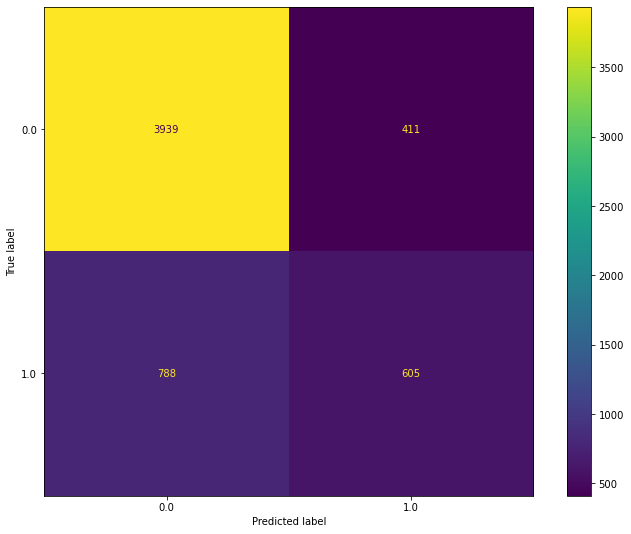

 ------------------- Zbiór zbalansowany ------------------------


DT: 	 F1: 	 0.7430447633472883
[[2735  617]
 [ 804 2741]]



RF: 	 F1: 	 0.7506547890508564
[[2699  653]
 [1065 2480]]


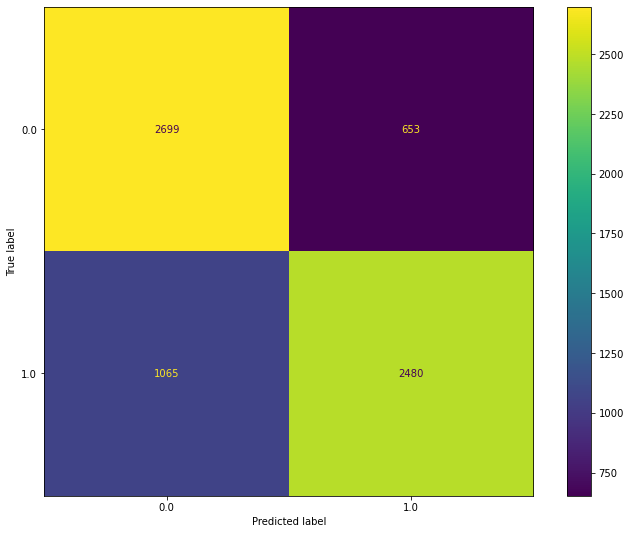

In [29]:

def decision_tree_clasification(cols, targ, feature_cols, max_depth, max_features, max_leaf_nodes):
    X_train, X_test, y_train, y_test = train_test_split(cols, targ, test_size=0.3, random_state=7)
    classifier = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, max_features=max_features,
                                        max_leaf_nodes=max_leaf_nodes, random_state=7)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    #print("Precyzja : ", accuracy_score(y_test, y_pred))
    #cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    #dframe = pd.DataFrame({'Prawdziwe y': y_test, 'Przewidywane y': y_pred})
    #print(dframe)
    #print("\n\n")

    return y_test, y_pred, cm, classifier




def random_forest_clasification(cols, targ, feature_cols, max_depth, max_features, max_leaf_nodes, min_samples_split):
    X_train, X_test, y_train, y_test = train_test_split(cols, targ, test_size=0.3, random_state=7)
    classifier = RandomForestClassifier(criterion='gini', max_depth=max_depth, max_features=max_features, max_leaf_nodes=max_leaf_nodes, min_samples_split=min_samples_split, n_jobs=-1, random_state=7)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test) 
    #print ("Precyzja : ", accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    #dframe = pd.DataFrame({'Prawdziwe y':y_test, 'Przewidywane y':y_pred})
    #print(dframe)
    print("\n")
    
    return y_test, y_pred, cm, classifier


print(" ------------------- Zbiór niezbalansowany ------------------------")

[y_true_dt, y_pred_dt, cm_dt, classifier_dt] = decision_tree_clasification(df[feature_cols], df['target'], feature_cols, 7, 8, 20)
[y_true_rf, y_pred_rf, cm_rf, classifier_rf] = random_forest_clasification(df[feature_cols], df['target'], feature_cols, 2, 7, 3, 2)
f1_dt = f1_score(y_true_dt, y_pred_dt, average='macro')
f1_rf = f1_score(y_true_rf, y_pred_rf, average='macro')
print("DT: \t F1: \t", f1_dt)
print(cm_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=classifier_dt.classes_)
disp.plot() 
plt.show()
print("\nRF: \t F1: \t", f1_rf)
print(cm_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=classifier_rf.classes_)
disp.plot() 
plt.show()


print(" ------------------- Zbiór zbalansowany ------------------------")

[y_true_dt, y_pred_dt, cm_dt, classifier_dt] = decision_tree_clasification(X_under, y_under, feature_cols, 7, 8, 20)
[y_true_rf, y_pred_rf, cm_rf, classifier_rf] = random_forest_clasification(X_under, y_under, feature_cols, 4, 8, 10, 2)
f1_dt = f1_score(y_true_dt, y_pred_dt, average='macro')
f1_rf = f1_score(y_true_rf, y_pred_rf, average='macro')
print("DT: \t F1: \t", f1_dt)
print(cm_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=classifier_dt.classes_)
disp.plot() 
plt.show()
print("\nRF: \t F1: \t", f1_rf)
print(cm_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=classifier_rf.classes_)
disp.plot() 
plt.show()


Mimo ustawienia tych samych parametrów 'random_state', uzyskane w sprawdzeniu wyniki różnią się od tych otrzymanych bezpośrednio z GridSearch, jednak są podobne.

## Randomized search

In [30]:
from sklearn.model_selection import RandomizedSearchCV




print(" ------------------- Zbiór zbalansowany ------------------------")

print("Decision tree")
parameters = {'criterion':['gini'], 'max_depth':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,20,25,30], 'max_features':[2,3,4,5,6,7,8], 'max_leaf_nodes':[3,4,5,6,7,8,9,10,12,15,20], 'random_state':[7]}
dt = DecisionTreeClassifier()
clf = RandomizedSearchCV(dt, parameters, scoring='f1_macro', n_jobs=-1, random_state=7)
clf.fit(X_under, y_under)
print(clf.best_params_)
print("Score: ", clf.best_score_)



print("Random forest")
parameters = {'criterion':['gini'], 'max_depth':[2,3,4,5], 'min_samples_split':[2,3], 'max_features':[5,6,7,8], 'max_leaf_nodes':[3,4,5,6,7,10], 'random_state':[7]}
#parameters = {'n_estimators':[10,50,100], 'criterion':['gini'], 'max_depth':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,20,25,30,40,50], 'min_samples_split':[2,3,4], 'max_features':[2,3,4,5,6,7,8], 'max_leaf_nodes':[3,4,5,6,7,8,9,10,12,15,20]}
rf = RandomForestClassifier()
clf = RandomizedSearchCV(rf, parameters, scoring='f1_macro', n_jobs=-1, random_state=7)
clf.fit(X_under, y_under)
print(clf.best_params_)
print("Score: ", clf.best_score_)


 ------------------- Zbiór zbalansowany ------------------------
Decision tree
{'random_state': 7, 'max_leaf_nodes': 20, 'max_features': 7, 'max_depth': 20, 'criterion': 'gini'}
Score:  0.7481583777207718
Random forest
{'random_state': 7, 'min_samples_split': 2, 'max_leaf_nodes': 10, 'max_features': 8, 'max_depth': 5, 'criterion': 'gini'}
Score:  0.7508915062996635


## Sprawdzenie dla wyżej wymienionych parametrów

 ------------------- Zbiór zbalansowany ------------------------


DT: 	 F1: 	 0.75637593630919
[[2735  617]
 [ 804 2741]]


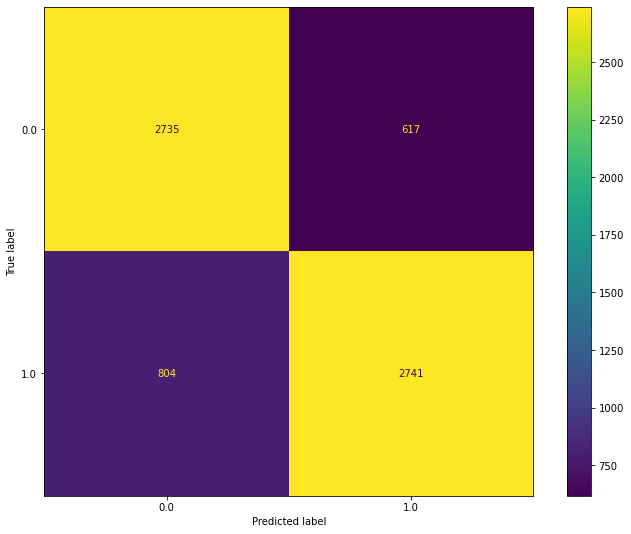


RF: 	 F1: 	 0.7495443280978158
[[2637  715]
 [1012 2533]]


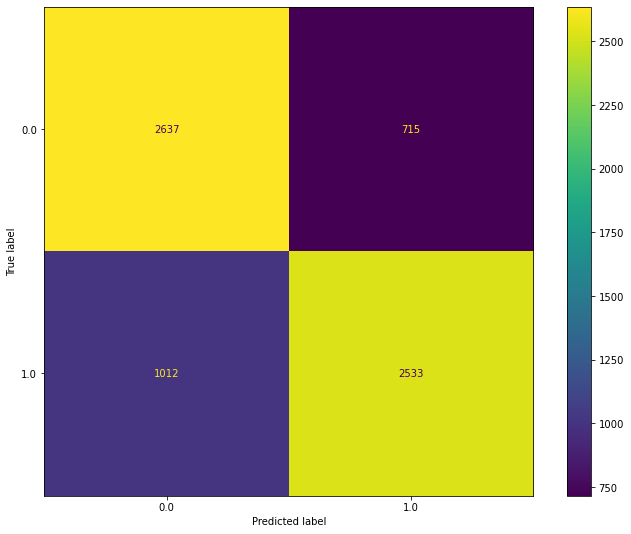

In [31]:
print(" ------------------- Zbiór zbalansowany ------------------------")

[y_true_dt, y_pred_dt, cm_dt, classifier_dt] = decision_tree_clasification(X_under, y_under, feature_cols, 20, 7, 20)
[y_true_rf, y_pred_rf, cm_rf, classifier_rf] = random_forest_clasification(X_under, y_under, feature_cols, 5, 8, 10, 2)
f1_dt = f1_score(y_true_dt, y_pred_dt, average='macro')
f1_rf = f1_score(y_true_rf, y_pred_rf, average='macro')
print("DT: \t F1: \t", f1_dt)
print(cm_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=classifier_dt.classes_)
disp.plot() 
plt.show()
print("\nRF: \t F1: \t", f1_rf)
print(cm_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=classifier_rf.classes_)
disp.plot() 
plt.show()

Mimo ustawienia tych samych parametrów 'random_state', uzyskane w sprawdzeniu wyniki różnią się od tych otrzymanych bezpośrednio z RandomizedSearch, jednak są podobne.

## Extra Trees Classifier

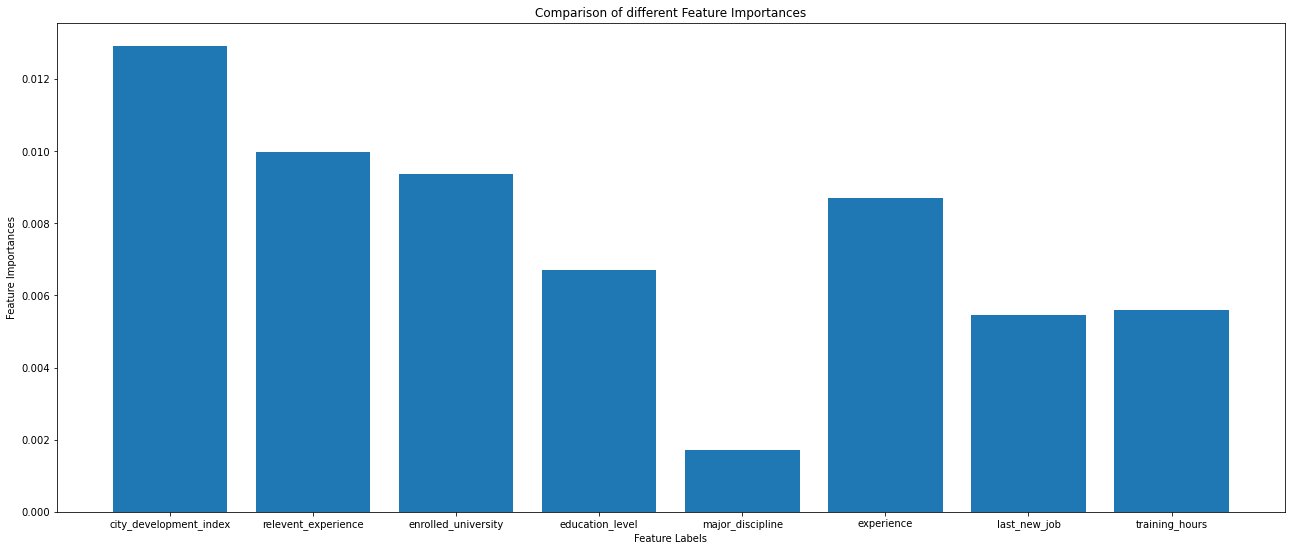

In [32]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=100, random_state=7, max_features=None, n_jobs=-1)
clf.fit(X_under, y_under)

feature_importance = clf.feature_importances_
  
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        clf.estimators_],
                                        axis = 0)
rcParams['figure.figsize'] = 22, 9

plt.bar(X_under.columns, feature_importance_normalized)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

Widzimy, że cechą mającą największe znaczenie dla modelu jest 'city_development_index' oraz 'experience' . Pozostałe cechy mają zbliżone znaczenie, natomiast cecha 'major_discipline' wypada najsłabiej.

Warto jednak zwrócić uwagę, że nawet dla najbardziej znaczącej cech wartość na osi Y jest bardzo niewielka, czego zresztą spodziewano się, mając w pamięci wyniki z tabeli korelacji.

## Optymalizacja alg. genetycznymi

Decision tree


C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning:

A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning:

A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.



gen	nevals	avg     	std      	min	max     
0  	1000  	0.506531	0.0323694	0.5	0.691359
1  	711   	0.517981	0.052198 	0.5	0.711601
2  	699   	0.537949	0.0702071	0.5	0.711601
3  	724   	0.578544	0.0840836	0.5	0.711601
4  	674   	0.634409	0.0708326	0.5	0.74207 
5  	711   	0.668243	0.0390141	0.5	0.739049
6  	663   	0.679004	0.0326889	0.5	0.74207 
7  	677   	0.693302	0.0264203	0.5	0.744196
8  	659   	0.709655	0.0195143	0.602256	0.751116
9  	695   	0.723041	0.0145251	0.5     	0.761036
10 	736   	0.732315	0.0146201	0.5     	0.777609
11 	727   	0.739555	0.00803158	0.627202	0.778532
12 	695   	0.7437  	0.01828   	0.5     	0.792137
13 	714   	0.751399	0.0150764 	0.5     	0.798585
14 	704   	0.762553	0.0135308 	0.670963	0.798585
15 	697   	0.772671	0.0106388 	0.670963	0.798585
16 	679   	0.778859	0.0114912 	0.5     	0.798585
17 	712   	0.7821  	0.0121397 	0.5     	0.798585
18 	734   	0.786265	0.00768759	0.670963	0.798585
19 	725   	0.790122	0.00778512	0.670963	0.798585
20 	717   	0.793867	0.007445

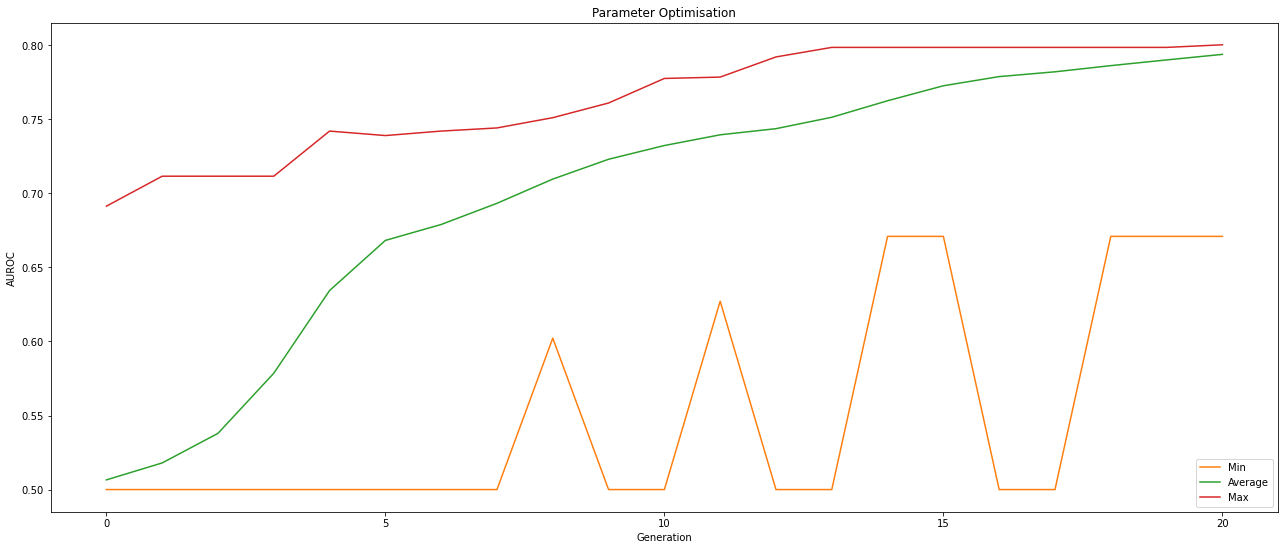



Random forest


C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning:

A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning:

A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.



gen	nevals	avg     	std      	min	max     
0  	100   	0.509215	0.0402277	0.5	0.698527
1  	68    	0.522586	0.0612483	0.5	0.699816
2  	78    	0.566818	0.091282 	0.5	0.726922
3  	65    	0.645259	0.0846387	0.5	0.726922
4  	80    	0.699515	0.0137773	0.670963	0.728292
5  	70    	0.712174	0.0145868	0.681596	0.759159
6  	68    	0.722317	0.00978514	0.698527	0.734963
7  	78    	0.727376	0.00396747	0.700446	0.734963
8  	70    	0.73041 	0.0037297 	0.723265	0.734963
9  	60    	0.733561	0.00271883	0.728193	0.734963
10 	68    	0.732546	0.0233812 	0.5     	0.734963
11 	64    	0.734963	1.11022e-16	0.734963	0.734963
12 	60    	0.734963	1.11022e-16	0.734963	0.734963
13 	78    	0.734963	1.11022e-16	0.734963	0.734963
14 	74    	0.734963	1.11022e-16	0.734963	0.734963
15 	74    	0.734896	0.00066369 	0.728292	0.734963
16 	80    	0.734963	1.11022e-16	0.734963	0.734963
17 	76    	0.734963	1.11022e-16	0.734963	0.734963
18 	72    	0.734963	1.11022e-16	0.734963	0.734963
19 	70    	0.734963	1.11022e-16	0.734963	0.7

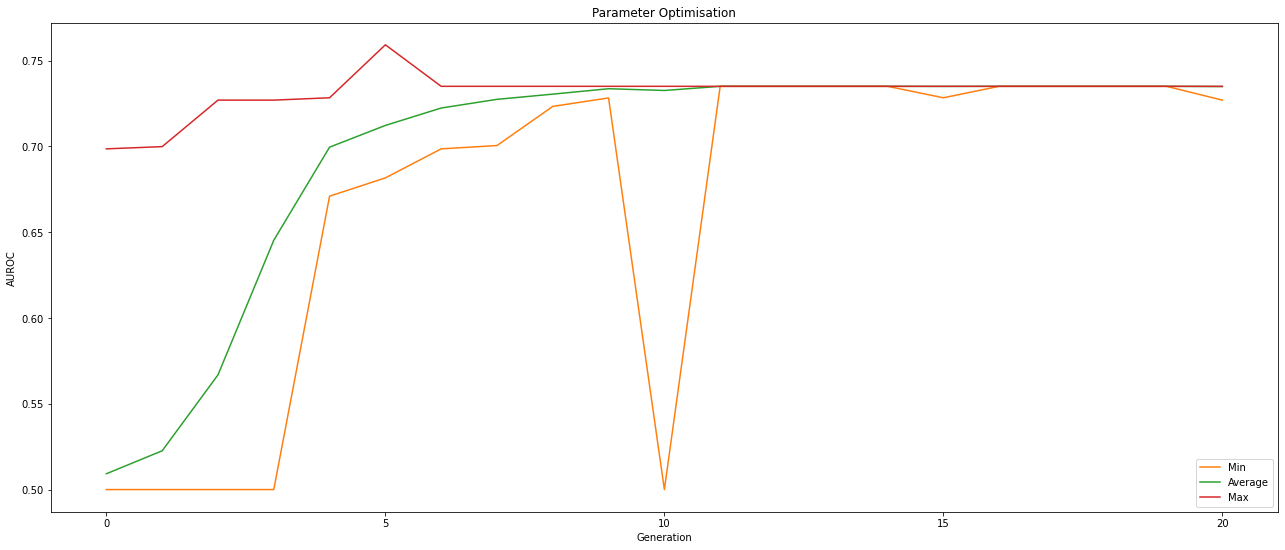

In [35]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import random

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=7)

# ---------------------------------------------------------------------------------------------------------------
print("Decision tree")
# ---------------------------------------------------------------------------------------------------------------

def mutate(individual):
    
    gene = random.randint(0,9) #select which parameter to mutate
    if gene == 0:
        if individual[0] == 'gini':
            individual[0] = 'entropy'
        else:
            individual[0] = 'gini'
        
    elif gene == 1:
        if individual[1] == 'best':
            individual[1] = 'random'
        else:
            individual[1] = 'best'
    
    elif gene == 2:
        individual[2] = random.randint(lower_depth, upper_depth)
        
    elif gene in [4,5]:
        individual[gene] = random.uniform(lower_samples_leaf, upper_samples_leaf)
        
    elif gene in [3,6,8]:
        individual[gene] = random.random()
        
    elif gene == 7:
        individual[7] = random.randint(lower_leaf_nodes, upper_leaf_nodes)
        
    elif gene == 9:
        if individual[9] == 'balanced':
            individual[9] = None
        else:
            individual[9] = 'balanced'        
        
    return individual,


def evaluate(individual):
    
    global X_train
    global y_train
    global X_test
    global y_test
    
    #build and test a model based on the parameters in an individual and return
    #the AUROC value
    
    # extract the values of the parameters from the individual chromosome
    crit = individual[0]
    split = individual[1]
    depth = individual[2]
    samples_split = individual[3]
    samples_leaf = individual[4]
    weight_fraction_leaf = individual[5]
    features = individual[6]
    leaf_nodes = individual[7]
    impurity_decrease = individual[8]
    class_weight = individual[9]
    
    # build the model
    model = DecisionTreeClassifier(criterion=crit, 
                                   splitter=split, 
                                   max_depth=depth, 
                                   min_samples_split=samples_split, 
                                   min_samples_leaf=samples_leaf, 
                                   min_weight_fraction_leaf=weight_fraction_leaf, 
                                   max_features=features, 
                                   max_leaf_nodes=leaf_nodes, 
                                   min_impurity_decrease=impurity_decrease, 
                                   class_weight=class_weight, 
                                   random_state=7,
                                   ).fit(X_train, y_train)
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    return roc_auc,

    


creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Maximise the fitness function value
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Possible parameter values
criterions = ['gini', 'entropy']
splits = ['best', 'random']
lower_depth, upper_depth = 2, 100 
lower_leaf_nodes, upper_leaf_nodes = 2, 100
class_weight = ['balanced', None]
lower_samples_leaf, upper_samples_leaf  = 0, 0.5


N_CYCLES = 1

toolbox.register("attr_crit", random.choice, criterions)
toolbox.register("attr_splitter", random.choice, splits)
toolbox.register("attr_depth", random.randint, lower_depth, upper_depth)
toolbox.register("attr_flt", random.random)
toolbox.register("attr_leaf_nodes", random.randint, lower_leaf_nodes, upper_leaf_nodes)
toolbox.register("attr_weight", random.choice, class_weight)
toolbox.register("attr_samples_leaf", random.uniform, lower_samples_leaf, upper_samples_leaf)


toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_crit, toolbox.attr_splitter, toolbox.attr_depth,
                 toolbox.attr_flt, toolbox.attr_samples_leaf, toolbox.attr_samples_leaf, 
                 toolbox.attr_flt, toolbox.attr_leaf_nodes,
                 toolbox.attr_flt, toolbox.attr_weight), n=N_CYCLES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate",mutate)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

population_size = 1000
crossover_probability = 0.7
mutation_probability = 0.01
number_of_generations = 20

pop = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=crossover_probability, stats = stats, 
                               mutpb = mutation_probability, ngen=number_of_generations, halloffame=hof, 
                               verbose=True) 

best_parameters = hof[0] # save the optimal set of parameters
print("Best parameters:   ", best_parameters)




gen = log.select("gen")
max_ = log.select("max")
avg = log.select("avg")
min_ = log.select("min")

evolution = pd.DataFrame({'Generation': gen,
                         'Max AUROC': max_,
                          'Average':avg,
                         'Min AUROC': min_})

plt.title('Parameter Optimisation')
plt.plot(evolution['Generation'], evolution['Min AUROC'], 'b', color = 'C1',
         label = 'Min')
plt.plot(evolution['Generation'], evolution['Average'], 'b', color = 'C2',
         label = 'Average')
plt.plot(evolution['Generation'], evolution['Max AUROC'], 'b', color = 'C3',
         label= 'Max')


plt.legend(loc = 'lower right')
plt.ylabel('AUROC')
plt.xlabel('Generation')
plt.xticks([0,5,10,15,20])
plt.show()

# ---------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------
print("\n\nRandom forest")


def mutate(individual):
    
    gene = random.randint(0,9) #select which parameter to mutate
    if gene == 0:
        if individual[0] == 'gini':
            individual[0] = 'entropy'
        else:
            individual[0] = 'gini'
        
    #elif gene == 1:
        #if individual[1] == 'best':
            #individual[1] = 'random'
        #else:
            #individual[1] = 'best'
    
    elif gene == 2:
        individual[2] = random.randint(lower_depth, upper_depth)
        
    elif gene in [4,5]:
        individual[gene] = random.uniform(lower_samples_leaf, upper_samples_leaf)
        
    elif gene in [3,6,8]:
        individual[gene] = random.random()
        
    elif gene == 7:
        individual[7] = random.randint(lower_leaf_nodes, upper_leaf_nodes)
        
    elif gene == 9:
        if individual[9] == 'balanced':
            individual[9] = None
        else:
            individual[9] = 'balanced'        
        
    return individual,


def evaluate(individual):
    
    global X_train
    global y_train
    global X_test
    global y_test
    
    #build and test a model based on the parameters in an individual and return
    #the AUROC value
    
    # extract the values of the parameters from the individual chromosome
    crit = individual[0]
    #split = individual[1]
    depth = individual[2]
    samples_split = individual[3]
    samples_leaf = individual[4]
    weight_fraction_leaf = individual[5]
    features = individual[6]
    leaf_nodes = individual[7]
    impurity_decrease = individual[8]
    class_weight = individual[9]
    
    
    # build the model
    model = RandomForestClassifier(criterion=crit, 
                                   max_depth=depth, 
                                   min_samples_split=samples_split, 
                                   min_samples_leaf=samples_leaf, 
                                   min_weight_fraction_leaf=weight_fraction_leaf, 
                                   max_features=features, 
                                   max_leaf_nodes=leaf_nodes, 
                                   min_impurity_decrease=impurity_decrease, 
                                   class_weight=class_weight, 
                                   random_state=7,
                                   ).fit(X_train, y_train)
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    return roc_auc,

    


creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Maximise the fitness function value
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()


# Possible parameter values
criterions = ['gini', 'entropy']
splits = ['best', 'random'] # not used here
lower_depth, upper_depth = 2, 100 
lower_leaf_nodes, upper_leaf_nodes = 2, 100
class_weight = ['balanced', None]
lower_samples_leaf, upper_samples_leaf  = 0, 0.5


N_CYCLES = 1

toolbox.register("attr_crit", random.choice, criterions)
toolbox.register("attr_splitter", random.choice, splits)
toolbox.register("attr_depth", random.randint, lower_depth, upper_depth)
toolbox.register("attr_flt", random.random)
toolbox.register("attr_leaf_nodes", random.randint, lower_leaf_nodes, upper_leaf_nodes)
toolbox.register("attr_weight", random.choice, class_weight)
toolbox.register("attr_samples_leaf", random.uniform, lower_samples_leaf, upper_samples_leaf)


toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_crit, toolbox.attr_splitter, toolbox.attr_depth,
                 toolbox.attr_flt, toolbox.attr_samples_leaf, toolbox.attr_samples_leaf, 
                 toolbox.attr_flt, toolbox.attr_leaf_nodes,
                 toolbox.attr_flt, toolbox.attr_weight), n=N_CYCLES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate",mutate)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

population_size = 100
crossover_probability = 0.7
mutation_probability = 0.01
number_of_generations = 20

pop = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=crossover_probability, stats = stats, 
                               mutpb = mutation_probability, ngen=number_of_generations, halloffame=hof, 
                               verbose=True) 

best_parameters = hof[0] # save the optimal set of parameters
print("Best parameters:   ", best_parameters)




gen = log.select("gen")
max_ = log.select("max")
avg = log.select("avg")
min_ = log.select("min")

evolution = pd.DataFrame({'Generation': gen,
                         'Max AUROC': max_,
                          'Average':avg,
                         'Min AUROC': min_})

plt.title('Parameter Optimisation')
plt.plot(evolution['Generation'], evolution['Min AUROC'], 'b', color = 'C1',
         label = 'Min')
plt.plot(evolution['Generation'], evolution['Average'], 'b', color = 'C2',
         label = 'Average')
plt.plot(evolution['Generation'], evolution['Max AUROC'], 'b', color = 'C3',
         label= 'Max')


plt.legend(loc = 'lower right')
plt.ylabel('AUROC')
plt.xlabel('Generation')
plt.xticks([0,5,10,15,20])
plt.show()






## Sprawdzenie dla wyżej wyliczonych wyników

###  !!!                   Tu nie zdążyłyśmy dokończyć                      !!!

In [34]:
print("DT: ")
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=7)
classifier = DecisionTreeClassifier(criterion='entropy', splitting='best', max_depth=51, min_samples_split = 0.058137351673780535, min_samples_leaf=0.011143771357591314, min_weight_fraction_leaf=0.011749242074536037, max_features=max_features,
                                        max_leaf_nodes=max_leaf_nodes, random_state=7)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("\n\n")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot() 
plt.show()



print("RF: ")
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=7)
classifier = RandomForestClassifier(criterion='gini', max_depth=max_depth, max_features=max_features, max_leaf_nodes=max_leaf_nodes, min_samples_split=min_samples_split, n_jobs=-1, random_state=7)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("\n\n")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot() 
plt.show()



DT: 


NameError: name 'max_features' is not defined

## Podsumowanie


 ------------------- Zbiór zbalansowany ------------------------
acc = 	 0.7939683920545164  	F1 = 	 0.7939682361293454


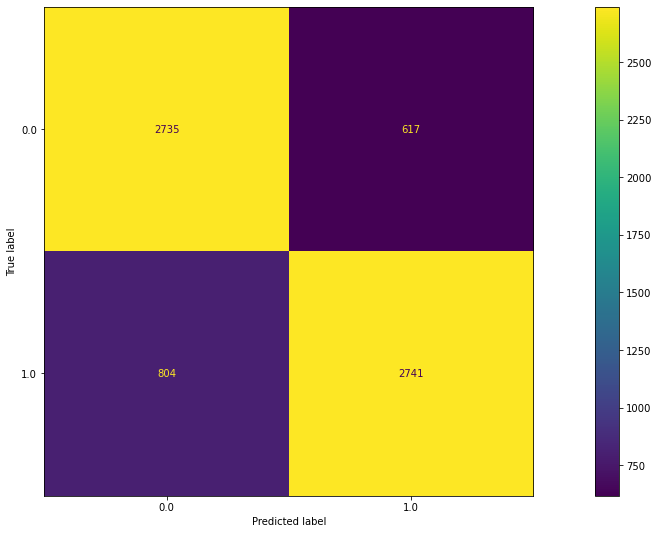

In [36]:

classifier_nb = CategoricalNB()
classifier_rf = RandomForestClassifier(criterion='gini', max_depth=50, max_features=None, n_jobs=-1, random_state=7)
classifier_svc = SVC(kernel='rbf', random_state=7)
classifier_nn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)


print(" ------------------- Zbiór zbalansowany ------------------------")
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=7)
eclf = StackingClassifier(estimators=[('svc', classifier_svc), ('nb', classifier_nb), ('nn', classifier_nn), ('rf', classifier_rf)], final_estimator=LogisticRegression())
#eclf = StackingClassifier(estimators=[('nb', classifier_nb), ('rf', classifier_rf)], final_estimator=classifier_nn)
eclf = eclf.fit(X_train, y_train)
pred_y = eclf.predict(X_test)
accuracy = accuracy_score(y_test, pred_y)
f1 = f1_score(y_test, pred_y, average='macro')
print("acc = \t", accuracy, " \tF1 = \t", f1)
cm = confusion_matrix(y_test, pred_y)
#print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=eclf.classes_)
disp.plot() 
plt.show()




### Najlepszy wynik predykcji uzyskano dla klasyfikatora: Stacking Classifier, wynik: 0.794838180241396